In [2]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_percentage_error, r2_score, mean_absolute_error
import pandas as pd
import torch.optim as optim
from catboost import CatBoostRegressor
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import gc
from sklearn.preprocessing import MinMaxScaler
import torch.nn.functional as F
import os
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
current_dir = os.getcwd()

parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(parent_dir, "TestSet")
print(f"Data directory: {data_dir}")

scaler_dir = os.path.join(current_dir, "Scaler")
print(f"Scaler directory: {scaler_dir}")

X_seq_test = np.load(os.path.join(data_dir, "X_seq_test.npy"))
X_static_test = np.load(os.path.join(data_dir, "X_static_test.npy"))
Y_test = np.load(os.path.join(data_dir, "Y_test.npy"))

print("Test set:", X_seq_test.shape, X_static_test.shape, Y_test.shape)

def load_minmax_scaler(path):
    data = np.load(path)
    return data["min_val"], data["max_val"]

X_seq_min, X_seq_max = load_minmax_scaler(
    os.path.join(scaler_dir, "X_seq_minmax_scaler.npz")
)
X_static_min, X_static_max = load_minmax_scaler(
    os.path.join(scaler_dir, "X_static_minmax_scaler.npz")
)
Y_min, Y_max = load_minmax_scaler(
    os.path.join(scaler_dir, "Y_static_minmax_scaler.npz")
)

def apply_minmax(x, min_val, max_val):
    return (x - min_val) / (max_val - min_val + 1e-8)

X_seq_test_flat = X_seq_test.reshape(-1, X_seq_test.shape[-1])
X_seq_test_norm = apply_minmax(X_seq_test_flat, X_seq_min, X_seq_max)
X_seq_test_norm = X_seq_test_norm.reshape(X_seq_test.shape)

X_static_test_norm = apply_minmax(X_static_test, X_static_min, X_static_max)
Y_test_norm = apply_minmax(Y_test, Y_min, Y_max)

case_dir = os.path.join(data_dir, "test_cases")
test_data_per_case = {}

if not os.path.isdir(case_dir):
    raise FileNotFoundError(f"Test condition catalog not found: {case_dir}")

case_ids = []
for fn in os.listdir(case_dir):
    if fn.startswith("X_seq_case") and fn.endswith(".npy"):
        cid = int(fn.replace("X_seq_case", "").replace(".npy", ""))
        case_ids.append(cid)
case_ids = sorted(case_ids)

for cid in case_ids:
    X_seq_case = np.load(os.path.join(case_dir, f"X_seq_case{cid}.npy"))
    X_static_case = np.load(os.path.join(case_dir, f"X_static_case{cid}.npy"))
    Y_case = np.load(os.path.join(case_dir, f"Y_case{cid}.npy"))

    test_data_per_case[cid] = (X_seq_case, X_static_case, Y_case)

print(f"✅ test_data_per_case : {len(test_data_per_case)} test case")

test_data_per_case_norm = {}

for cid, (X_seq_case, X_static_case, Y_case) in test_data_per_case.items():

    X_seq_flat = X_seq_case.reshape(-1, X_seq_case.shape[-1])
    X_seq_case_norm = apply_minmax(X_seq_flat, X_seq_min, X_seq_max)
    X_seq_case_norm = X_seq_case_norm.reshape(X_seq_case.shape)

    X_static_case_norm = apply_minmax(X_static_case, X_static_min, X_static_max)
    Y_case_norm = apply_minmax(Y_case, Y_min, Y_max)

    X_seq_case_norm = X_seq_case_norm.reshape(-1, 100, 2)
    X_static_case_norm = X_static_case_norm.reshape(-1, 1)

    X_case_norm = torch.cat(
        [
            torch.tensor(X_seq_case_norm, dtype=torch.float32),
            torch.tensor(X_static_case_norm, dtype=torch.float32)
            .unsqueeze(1)
            .expand(-1, 100, -1),
        ],
        dim=-1,
    )

    test_data_per_case_norm[cid] = (X_case_norm, Y_case_norm)

print("✅ test_data_per_case_norm established")

X_seq_test_t = torch.tensor(X_seq_test_norm, dtype=torch.float32)
X_static_test_t = torch.tensor(X_static_test_norm, dtype=torch.float32)
Y_test_t = torch.tensor(Y_test_norm, dtype=torch.float32)

test_X = torch.cat(
    [X_seq_test_t, X_static_test_t.unsqueeze(1).expand(-1, 100, -1)],
    dim=-1,
)

test_dataset = TensorDataset(test_X, Y_test_t)

batch_size = 256
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)

Data directory: d:\0DATA\NHRI\Python Code\4、代理模型_水深预测\GitHub\上传 - 1.5\TestSet
Scaler directory: d:\0DATA\NHRI\Python Code\4、代理模型_水深预测\GitHub\上传 - 1.5\4_GRU\Scaler
Test set: (13006, 100, 2) (13006, 1) (13006, 6)
✅ test_data_per_case : 9 test case
✅ test_data_per_case_norm established


In [4]:
class GRURegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=3, output_dim=6, dropout=0.3):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.gru(x)           
        out = out[:, -1, :]            
        out = self.fc(out)             
        return out

In [5]:
Y_min_t = torch.tensor(Y_min, dtype=torch.float32, device=device)   
Y_max_t = torch.tensor(Y_max, dtype=torch.float32, device=device)  
Y_range_t = (Y_max_t - Y_min_t).clamp_min(1e-8)                   

In [6]:
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

current_dir = os.getcwd()
data_dir = os.path.join(current_dir, "Best_GRU.pth")  
print(f"Data directory: {data_dir}")

best_model = torch.load(data_dir, weights_only = False)

Data directory: d:\0DATA\NHRI\Python Code\4、代理模型_水深预测\GitHub\上传 - 1.5\4_GRU\Best_GRU.pth


In [7]:
print(best_model)

GRURegressor(
  (gru): GRU(3, 128, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)


In [8]:
import numpy as np

def median_absolute_error(y_true, y_pred):
    """
    Median Absolute Error (MdAE)
    """
    errors = np.abs(y_true - y_pred)
    return np.median(errors)

def iqr_based_mae(y_true, y_pred):
    errors = np.abs(y_true - y_pred).flatten()  
    q1 = np.percentile(errors, 25)
    q3 = np.percentile(errors, 75)
    mask = (errors >= q1) & (errors <= q3)
    filtered_errors = errors[mask]
    if len(filtered_errors) == 0:
        return np.nan  
    return np.mean(filtered_errors)


def NSE_global(y_true, y_pred, eps=1e-12):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    num = np.sum((y_true - y_pred) ** 2)
    den = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1.0 - num / (den + eps)


def R2_global(y_true, y_pred, eps=1e-12):
    return NSE_global(y_true, y_pred, eps=eps)


def NSE(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)


def hit_rate(y_true, y_pred, delta):
    relative_errors = np.abs((y_pred - y_true) / y_true) * 100  
    hits = relative_errors <= delta
    return np.mean(hits) * 100 

def KGE(y_true, y_pred):
    """Kling–Gupta Efficiency"""
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    r = np.corrcoef(y_true, y_pred)[0, 1]
    beta = np.mean(y_pred) / np.mean(y_true)
    gamma = (np.std(y_pred) / np.mean(y_pred)) / (np.std(y_true) / np.mean(y_true))
    kge = 1 - np.sqrt((r - 1)**2 + (beta - 1)**2 + (gamma - 1)**2)
    return kge

def willmott_index_modified(observed, predicted):
    """
    Willmott's Modified Index of Agreement (Willmott et al., 2012)
    """
    observed = np.array(observed)
    predicted = np.array(predicted)
    
    numerator = np.sum(np.abs(predicted - observed))
    denominator = 2 * np.sum(np.abs(observed - np.mean(observed)))
    
    if denominator == 0:
        return 1.0 if numerator == 0 else 0.0
    
    d = 1 - (numerator / denominator)
    return np.clip(d, 0, 1)

max_delta=5
deltas = np.arange(0.25, max_delta+0.25, 0.25)  
print(deltas)

def evaluate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true))
    r2 = R2_global(y_true, y_pred) 
    nse = NSE_global(y_true, y_pred)  
    kge = KGE(y_true, y_pred)
    d_index = willmott_index_modified(y_true, y_pred)
    hr = [hit_rate(y_true, y_pred, d) for d in deltas]
    mdae = median_absolute_error(y_true, y_pred)
    iqr_mae = iqr_based_mae(y_true, y_pred)
    max_err = np.max(np.abs(y_true - y_pred))
    return {
        'MSE': mse, 'RMSE': rmse, 'MAPE': mape, 'MAE': mae,
        'R2': r2, 'NSE': nse, 'KGE': kge, 'd': d_index,
        'HitRate': hr, 'MdAE': mdae, 'IQR-based MAE': iqr_mae, 'MaxError': max_err
    }


[0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25 3.5
 3.75 4.   4.25 4.5  4.75 5.  ]


In [9]:
best_model = best_model.to(device)
best_model.eval()

def predict_norm(model, X_seq_norm, device):
    model.eval()
    X_seq_t = torch.tensor(X_seq_norm, dtype=torch.float32, device=device)

    with torch.no_grad():
        out = model(X_seq_t)  
        out = out.squeeze(1)  
        return out.detach().cpu().numpy()

def denorm_y(y_norm, Y_min, Y_max):
    return y_norm * (Y_max - Y_min) + Y_min

print("\n===================== Test condition indicators (output first) =====================")

case_metrics = {}  

for cid in sorted(test_data_per_case_norm.keys()):
    X_case_norm, Y_case_norm = test_data_per_case_norm[cid]

    y_pred_case_norm = predict_norm(best_model, X_case_norm, device)

    y_pred_case_real = denorm_y(y_pred_case_norm, Y_min, Y_max)
    y_true_case_real = denorm_y(Y_case_norm, Y_min, Y_max)

    metrics_case = evaluate_metrics(y_true_case_real, y_pred_case_real)
    case_metrics[cid] = metrics_case

    print(f"\n--- Case {cid} ---")
    for k, v in metrics_case.items():
        if k != "HitRate":
            print(f"{k}: {v:.6f}")
        else:
            hr_str = ", ".join([f"{h:.2f}" for h in v])
            print(f"HitRate(δ=1~{max_delta}%): [{hr_str}]")

print("\n===================== The metrics for the entire test set (final output) =====================")

y_pred_total_norm = predict_norm(best_model, test_X, device)

y_pred_total_real = denorm_y(y_pred_total_norm, Y_min, Y_max)
y_true_total_real = denorm_y(Y_test_norm, Y_min, Y_max)

metrics_total = evaluate_metrics(y_true_total_real, y_pred_total_real)

print("\n--- Ful test set overall ---")
for k, v in metrics_total.items():
    if k != "HitRate":
        print(f"{k}: {v:.6f}")
    else:
        hr_str = ", ".join([f"{h:.2f}" for h in v])
        print(f"HitRate(δ=1~{max_delta}%): [{hr_str}]")



===================== Test condition indicators (output first) =====================

--- Case 3 ---
MSE: 0.003479
RMSE: 0.058985
MAPE: 0.004367
MAE: 0.050870
R2: 0.905693
NSE: 0.905693
KGE: 0.948124
d: 0.835603
HitRate(δ=1~5%): [26.98, 60.05, 86.23, 98.95, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00]
MdAE: 0.048428
IQR-based MAE: 0.049028
MaxError: 0.143673

--- Case 6 ---
MSE: 0.014354
RMSE: 0.119810
MAPE: 0.007155
MAE: 0.102732
R2: 0.489911
NSE: 0.489911
KGE: 0.907073
d: 0.638051
HitRate(δ=1~5%): [16.49, 34.65, 55.59, 71.56, 89.18, 95.67, 99.59, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00]
MdAE: 0.096866
IQR-based MAE: 0.100309
MaxError: 0.257245

--- Case 13 ---
MSE: 0.007828
RMSE: 0.088474
MAPE: 0.006679
MAE: 0.075345
R2: 0.834082
NSE: 0.834082
KGE: 0.867185
d: 0.794499
HitRate(δ=1~5%): [19.82, 37.70, 54.42, 80.31, 94.14, 96.35, 98.50, 99.5

C:\Users\Administrator\AppData\Local\Temp\ipykernel_30024\2836716438.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_seq_t = torch.tensor(X_seq_norm, dtype=torch.float32, device=device)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_30024\2836716438.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_seq_t = torch.tensor(X_seq_norm, dtype=torch.float32, device=device)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_30024\2836716438.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_seq_t = torch.tensor(X_seq_norm, dtyp


--- Case 15 ---
MSE: 0.008346
RMSE: 0.091356
MAPE: 0.005981
MAE: 0.076420
R2: 0.689050
NSE: 0.689050
KGE: 0.887534
d: 0.728542
HitRate(δ=1~5%): [26.18, 45.25, 61.84, 81.84, 94.71, 99.33, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00]
MdAE: 0.075505
IQR-based MAE: 0.074095
MaxError: 0.216447

--- Case 22 ---
MSE: 0.001626
RMSE: 0.040325
MAPE: 0.003059
MAE: 0.035031
R2: 0.948868
NSE: 0.948868
KGE: 0.974840
d: 0.877743
HitRate(δ=1~5%): [39.59, 84.34, 99.71, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00]
MdAE: 0.034400
IQR-based MAE: 0.034665
MaxError: 0.092049

--- Case 24 ---
MSE: 0.005984
RMSE: 0.077355
MAPE: 0.005107
MAE: 0.065198
R2: 0.850220
NSE: 0.850220
KGE: 0.958385
d: 0.793444
HitRate(δ=1~5%): [27.34, 52.00, 72.68, 91.62, 99.92, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.

C:\Users\Administrator\AppData\Local\Temp\ipykernel_30024\2836716438.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_seq_t = torch.tensor(X_seq_norm, dtype=torch.float32, device=device)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_30024\2836716438.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_seq_t = torch.tensor(X_seq_norm, dtype=torch.float32, device=device)



--- Ful test set overall ---
MSE: 0.023515
RMSE: 0.153345
MAPE: 0.008334
MAE: 0.121075
R2: 0.994667
NSE: 0.994667
KGE: 0.970180
d: 0.966453
HitRate(δ=1~5%): [16.37, 33.77, 48.24, 65.55, 78.01, 85.91, 92.77, 96.51, 98.45, 99.57, 99.90, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00]
MdAE: 0.099946
IQR-based MAE: 0.102273
MaxError: 0.493418


C:\Users\Administrator\AppData\Local\Temp\ipykernel_30024\2836716438.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_seq_t = torch.tensor(X_seq_norm, dtype=torch.float32, device=device)


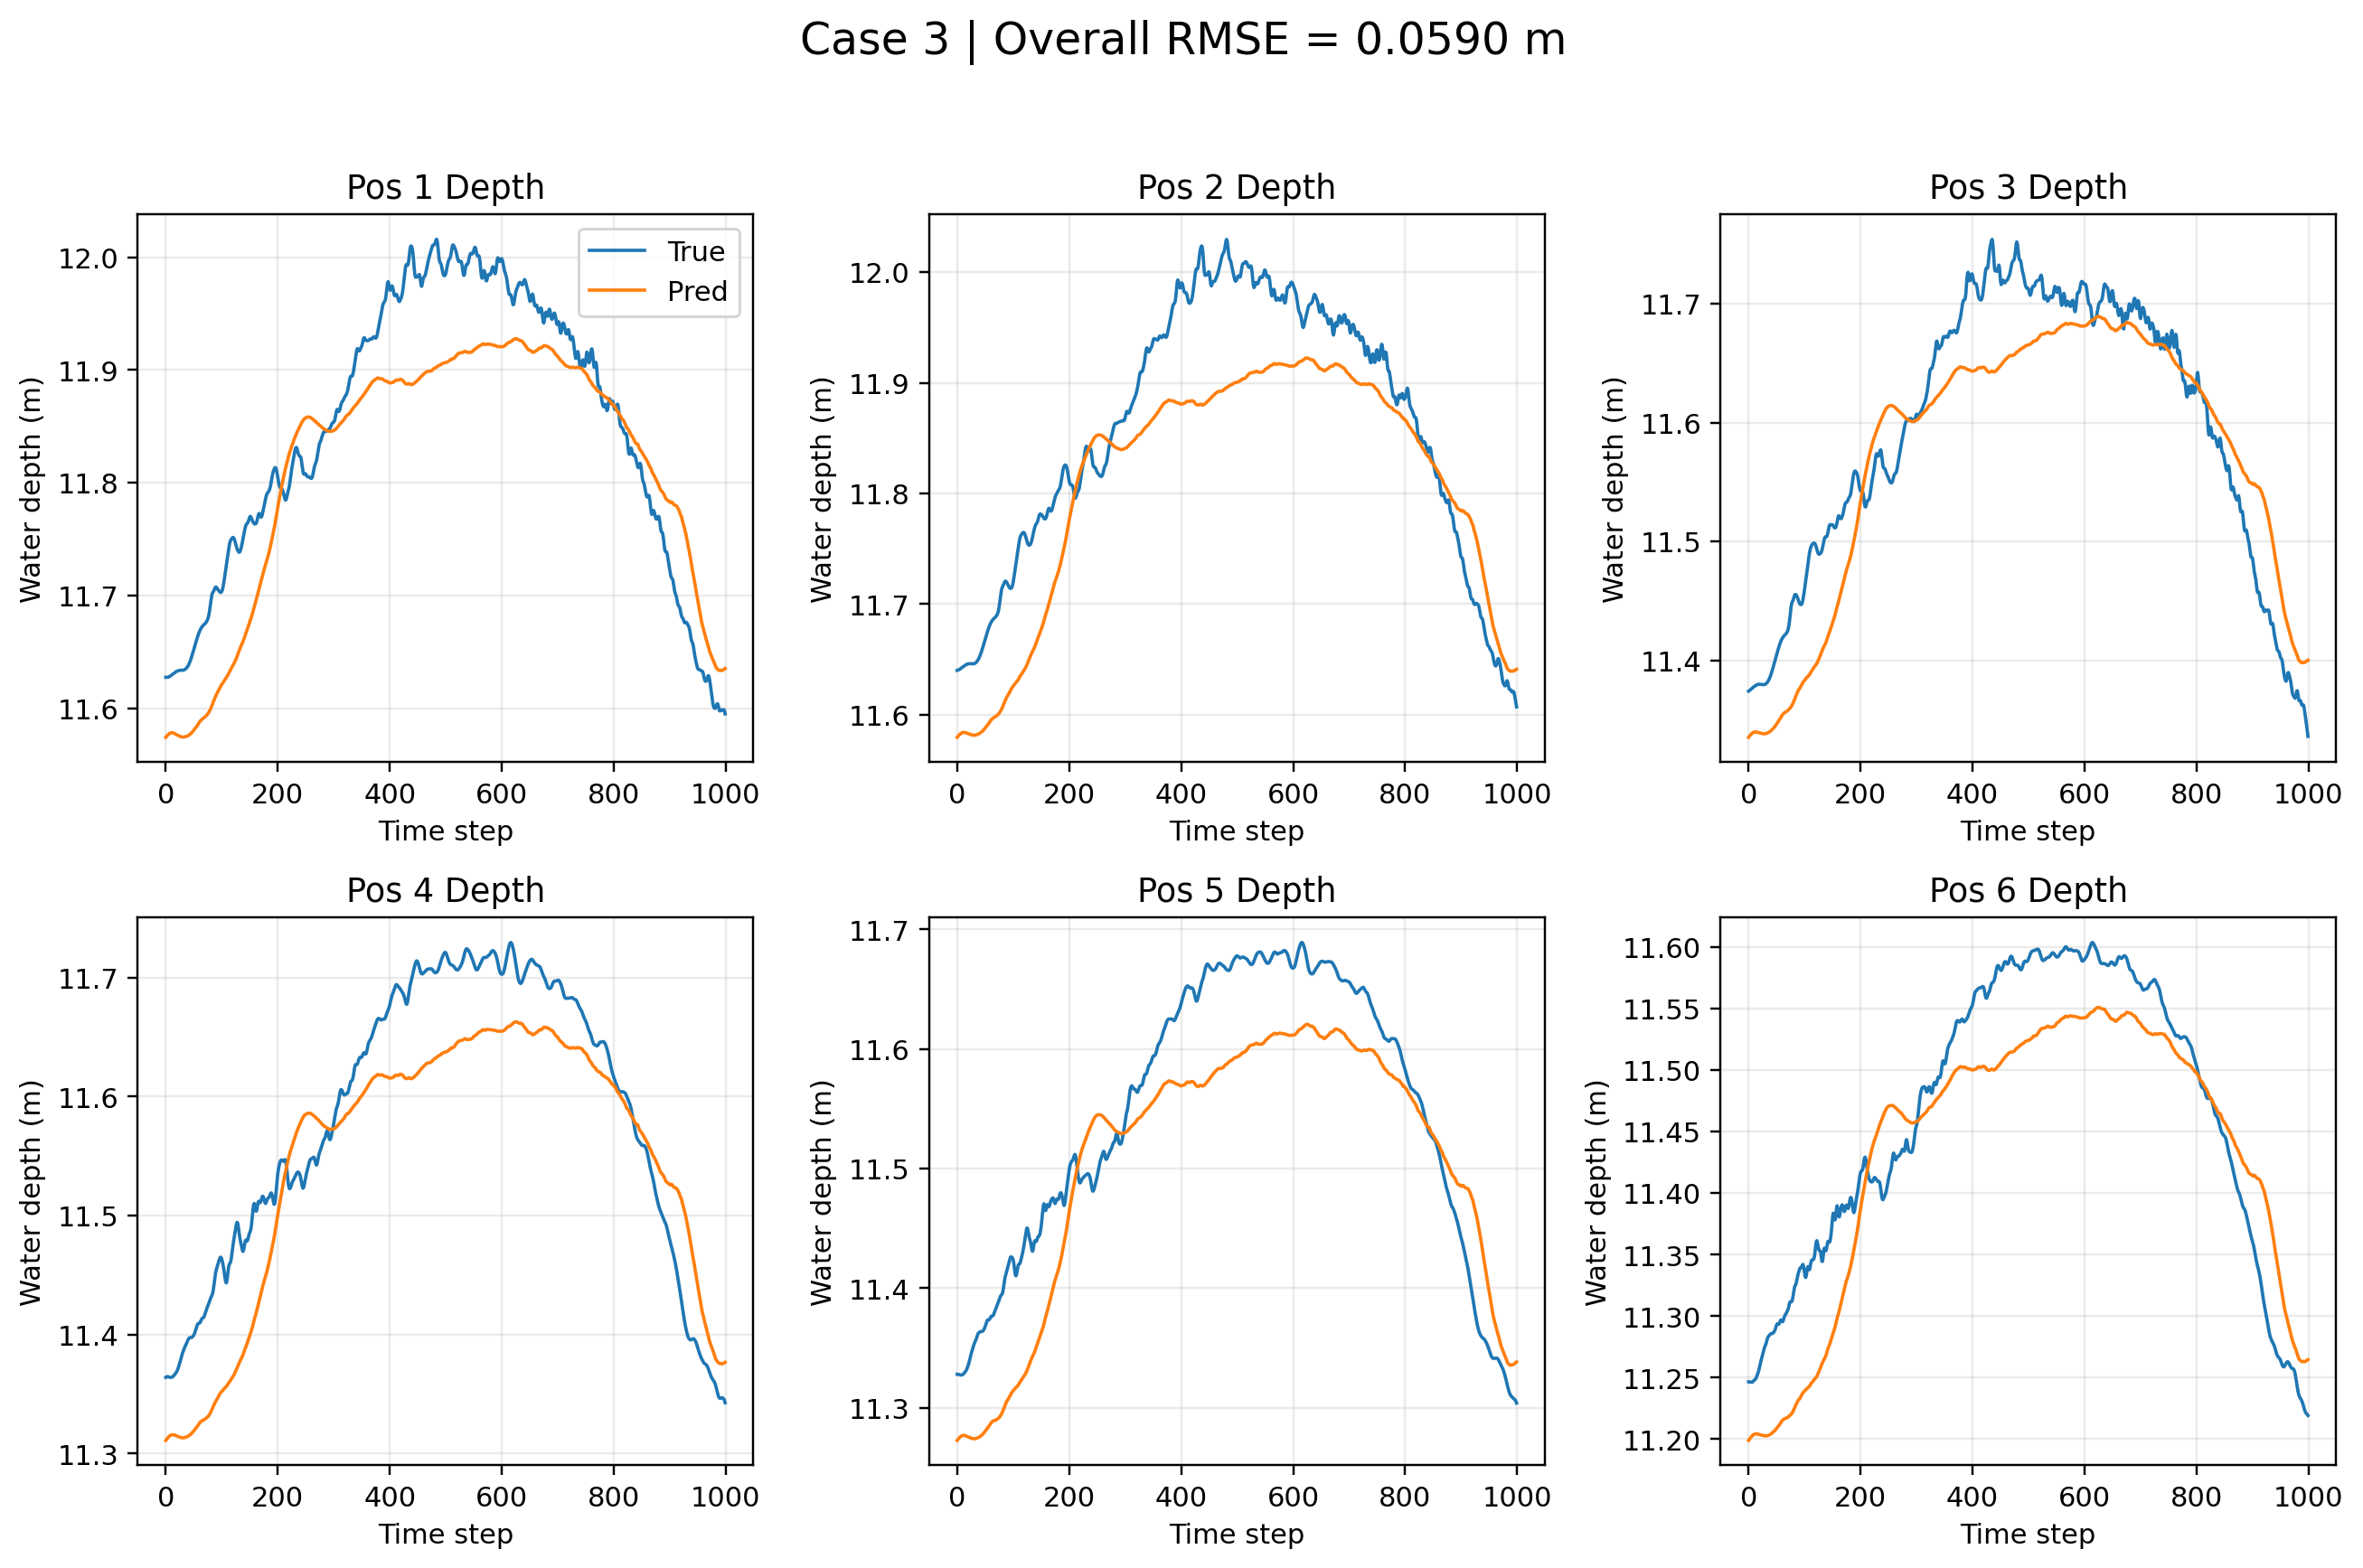

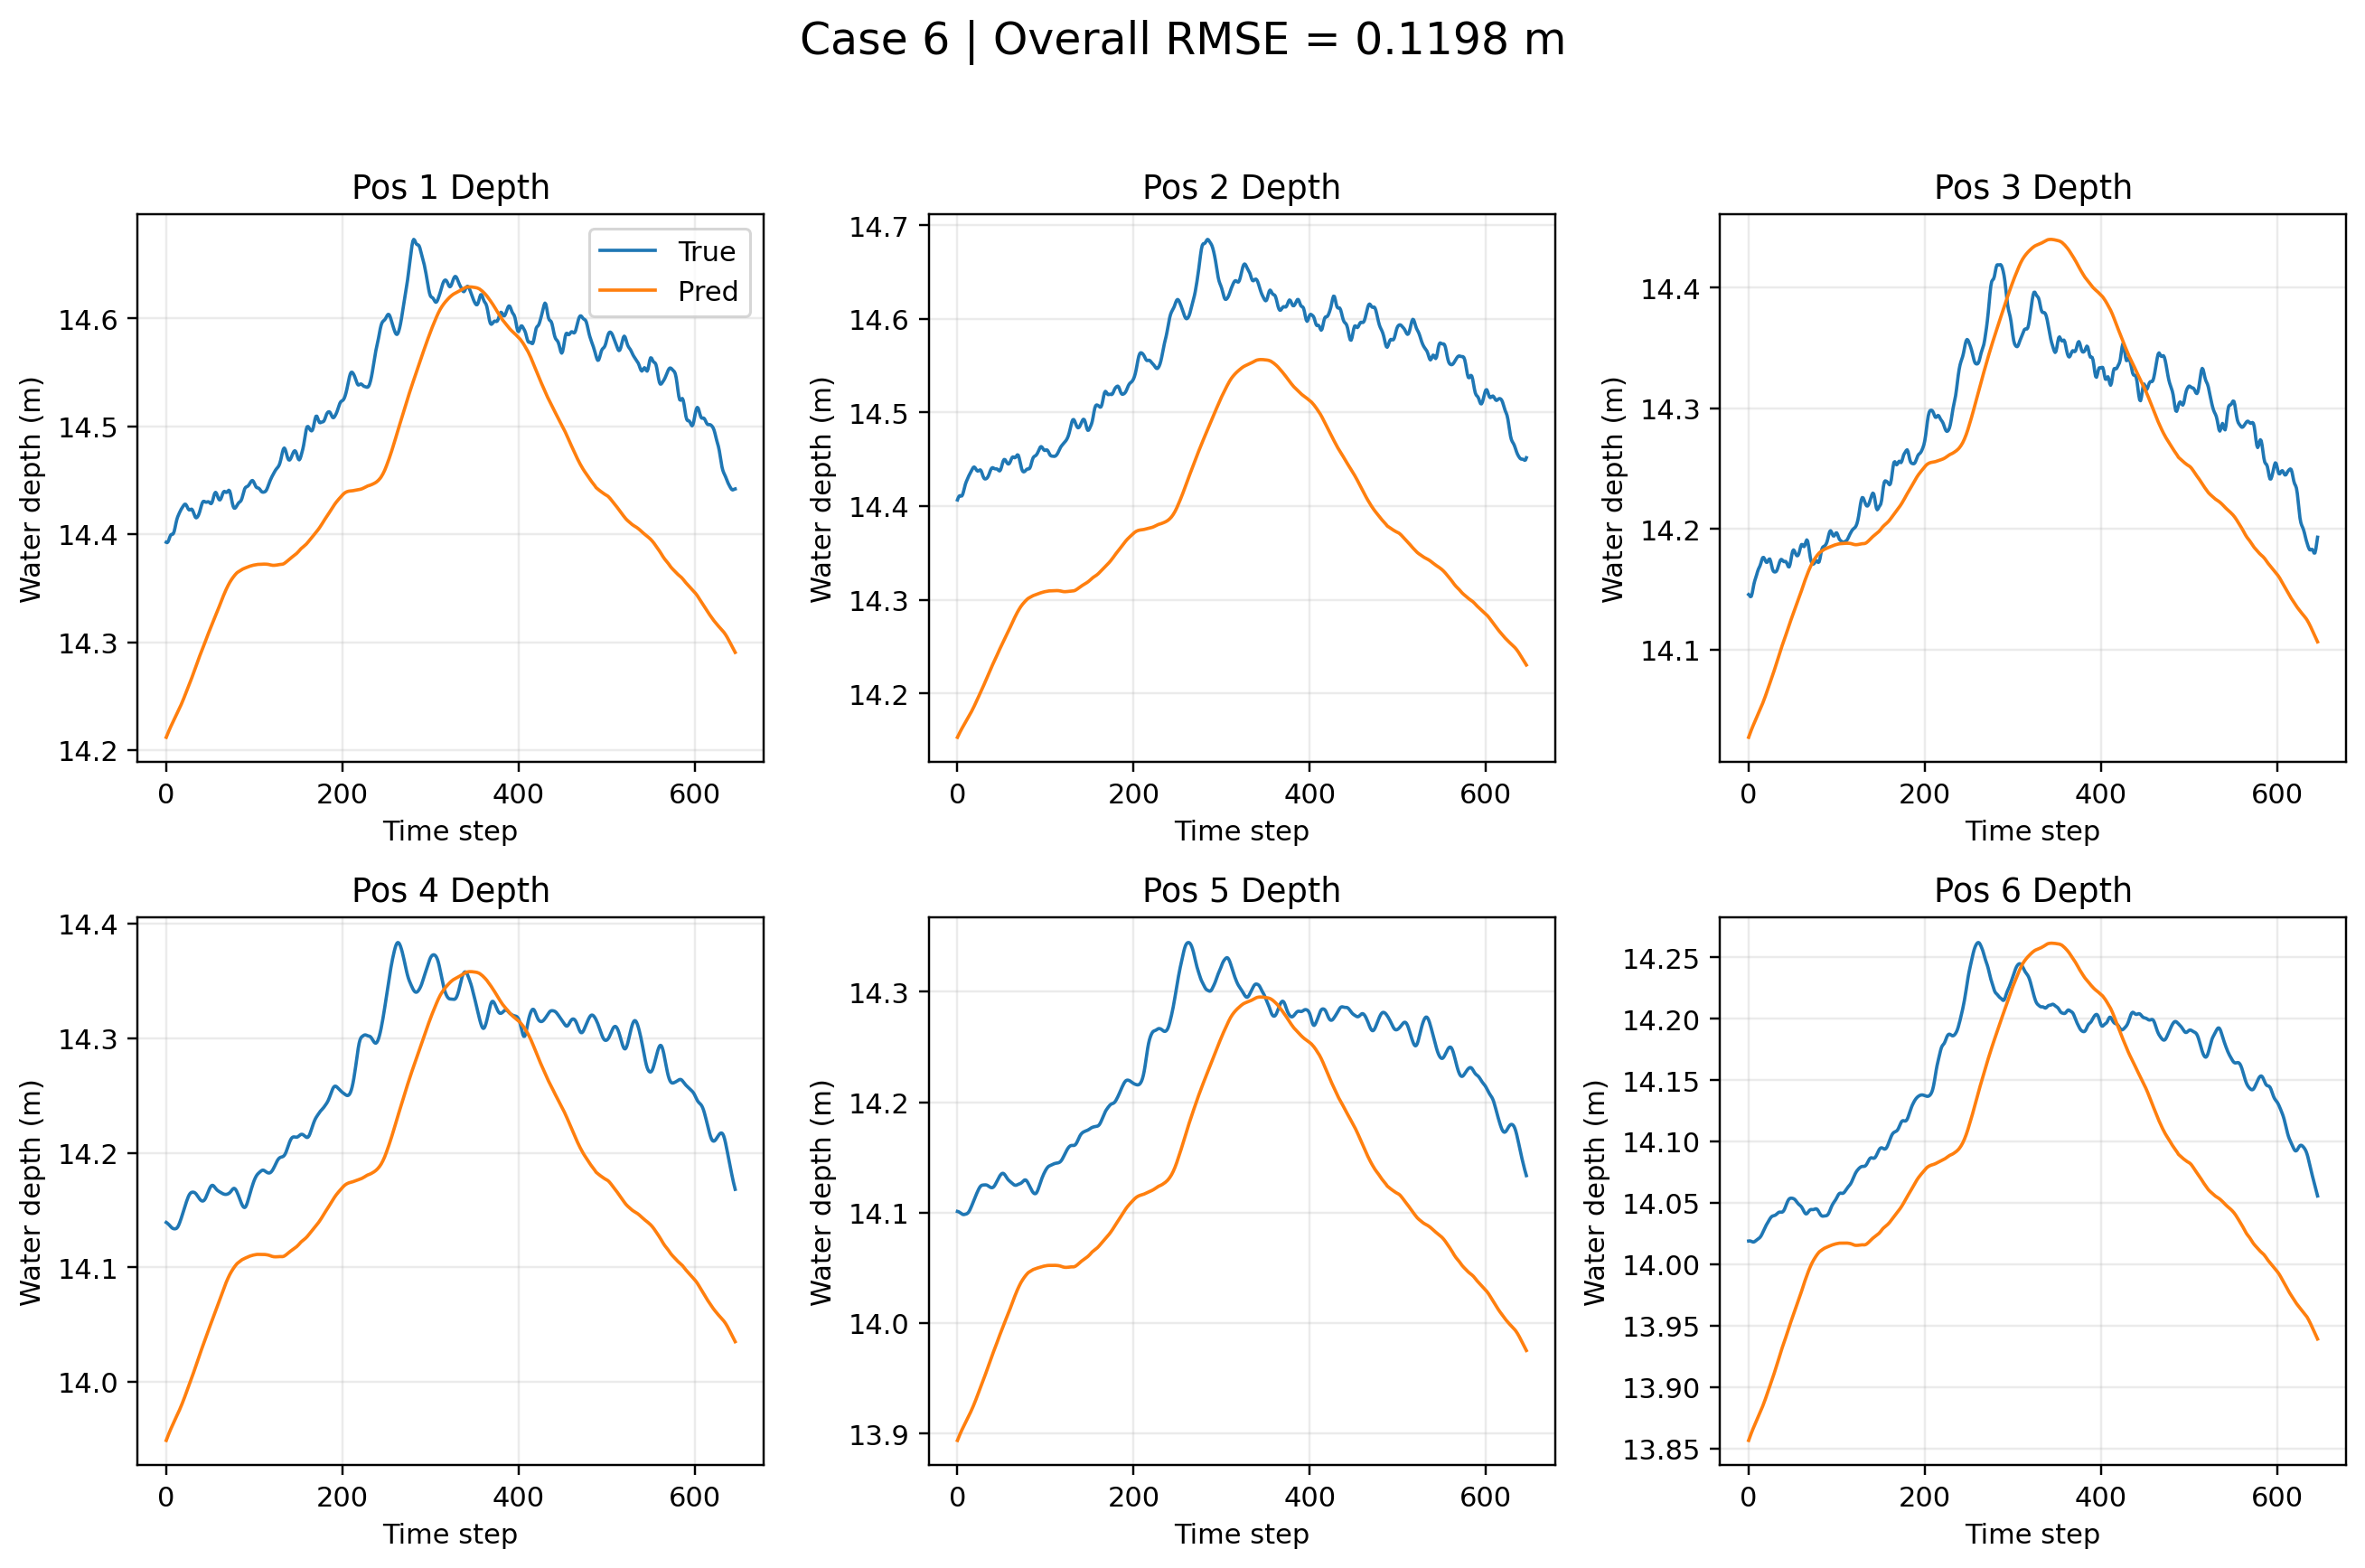

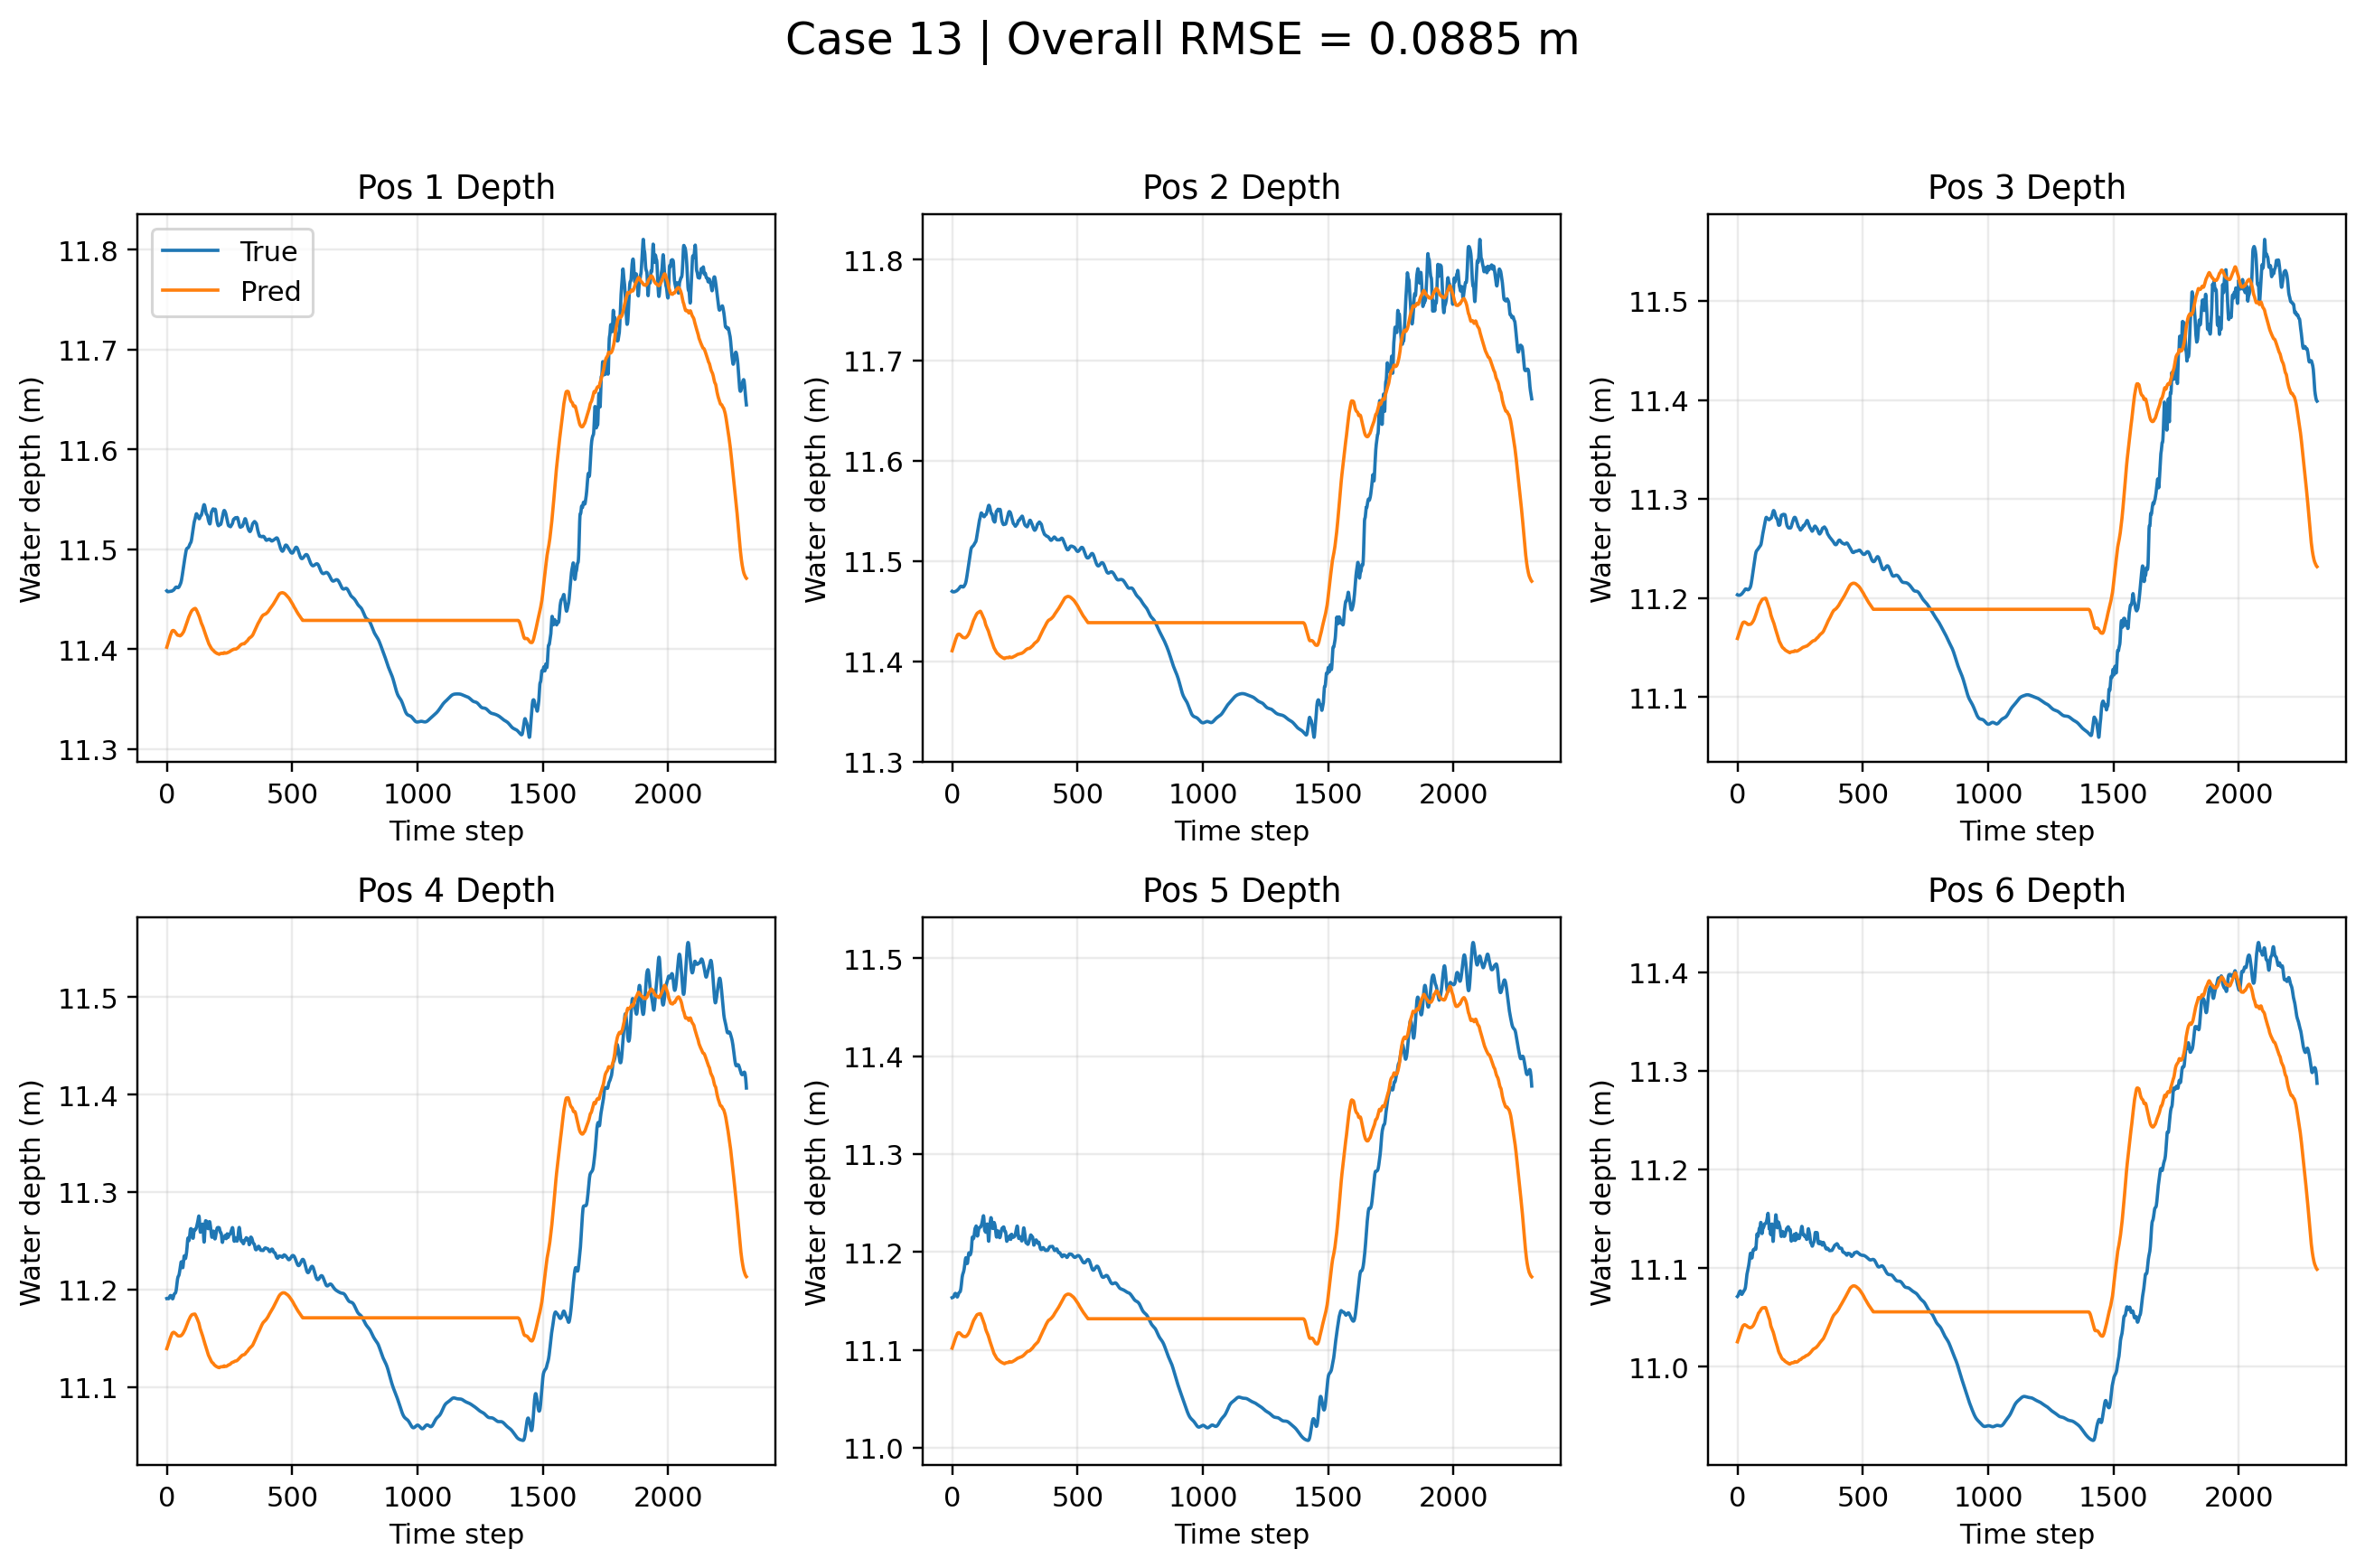

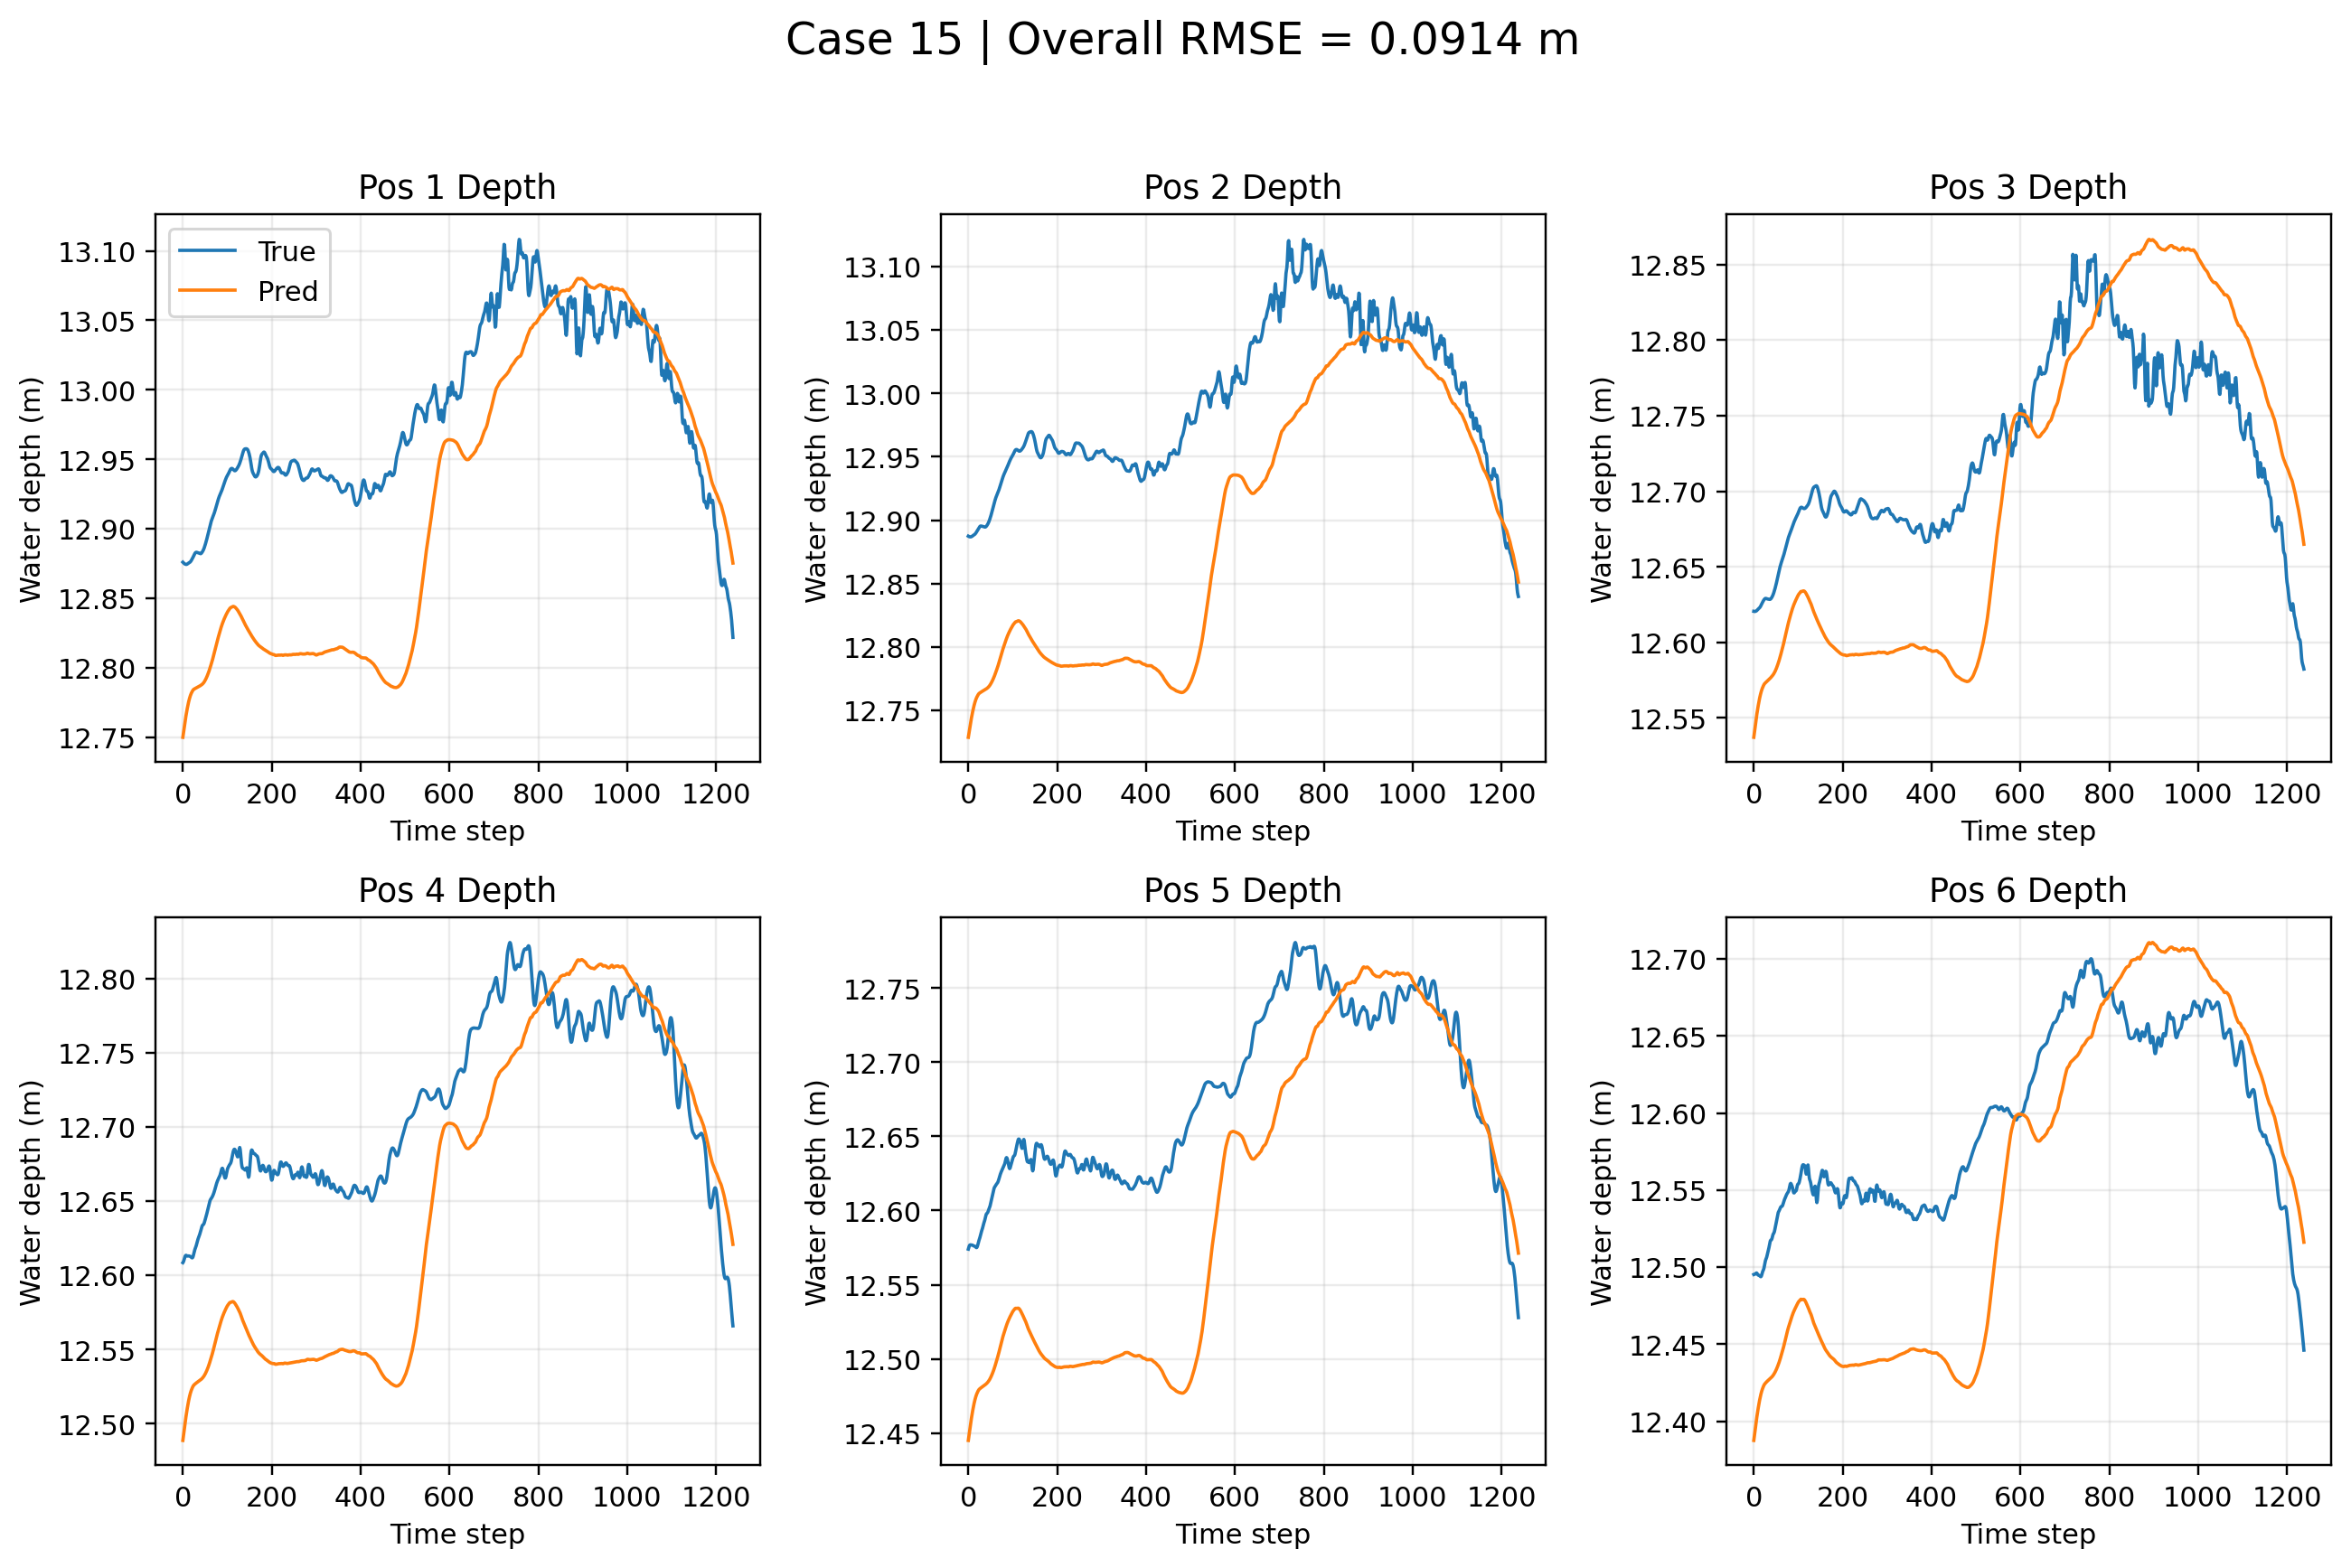

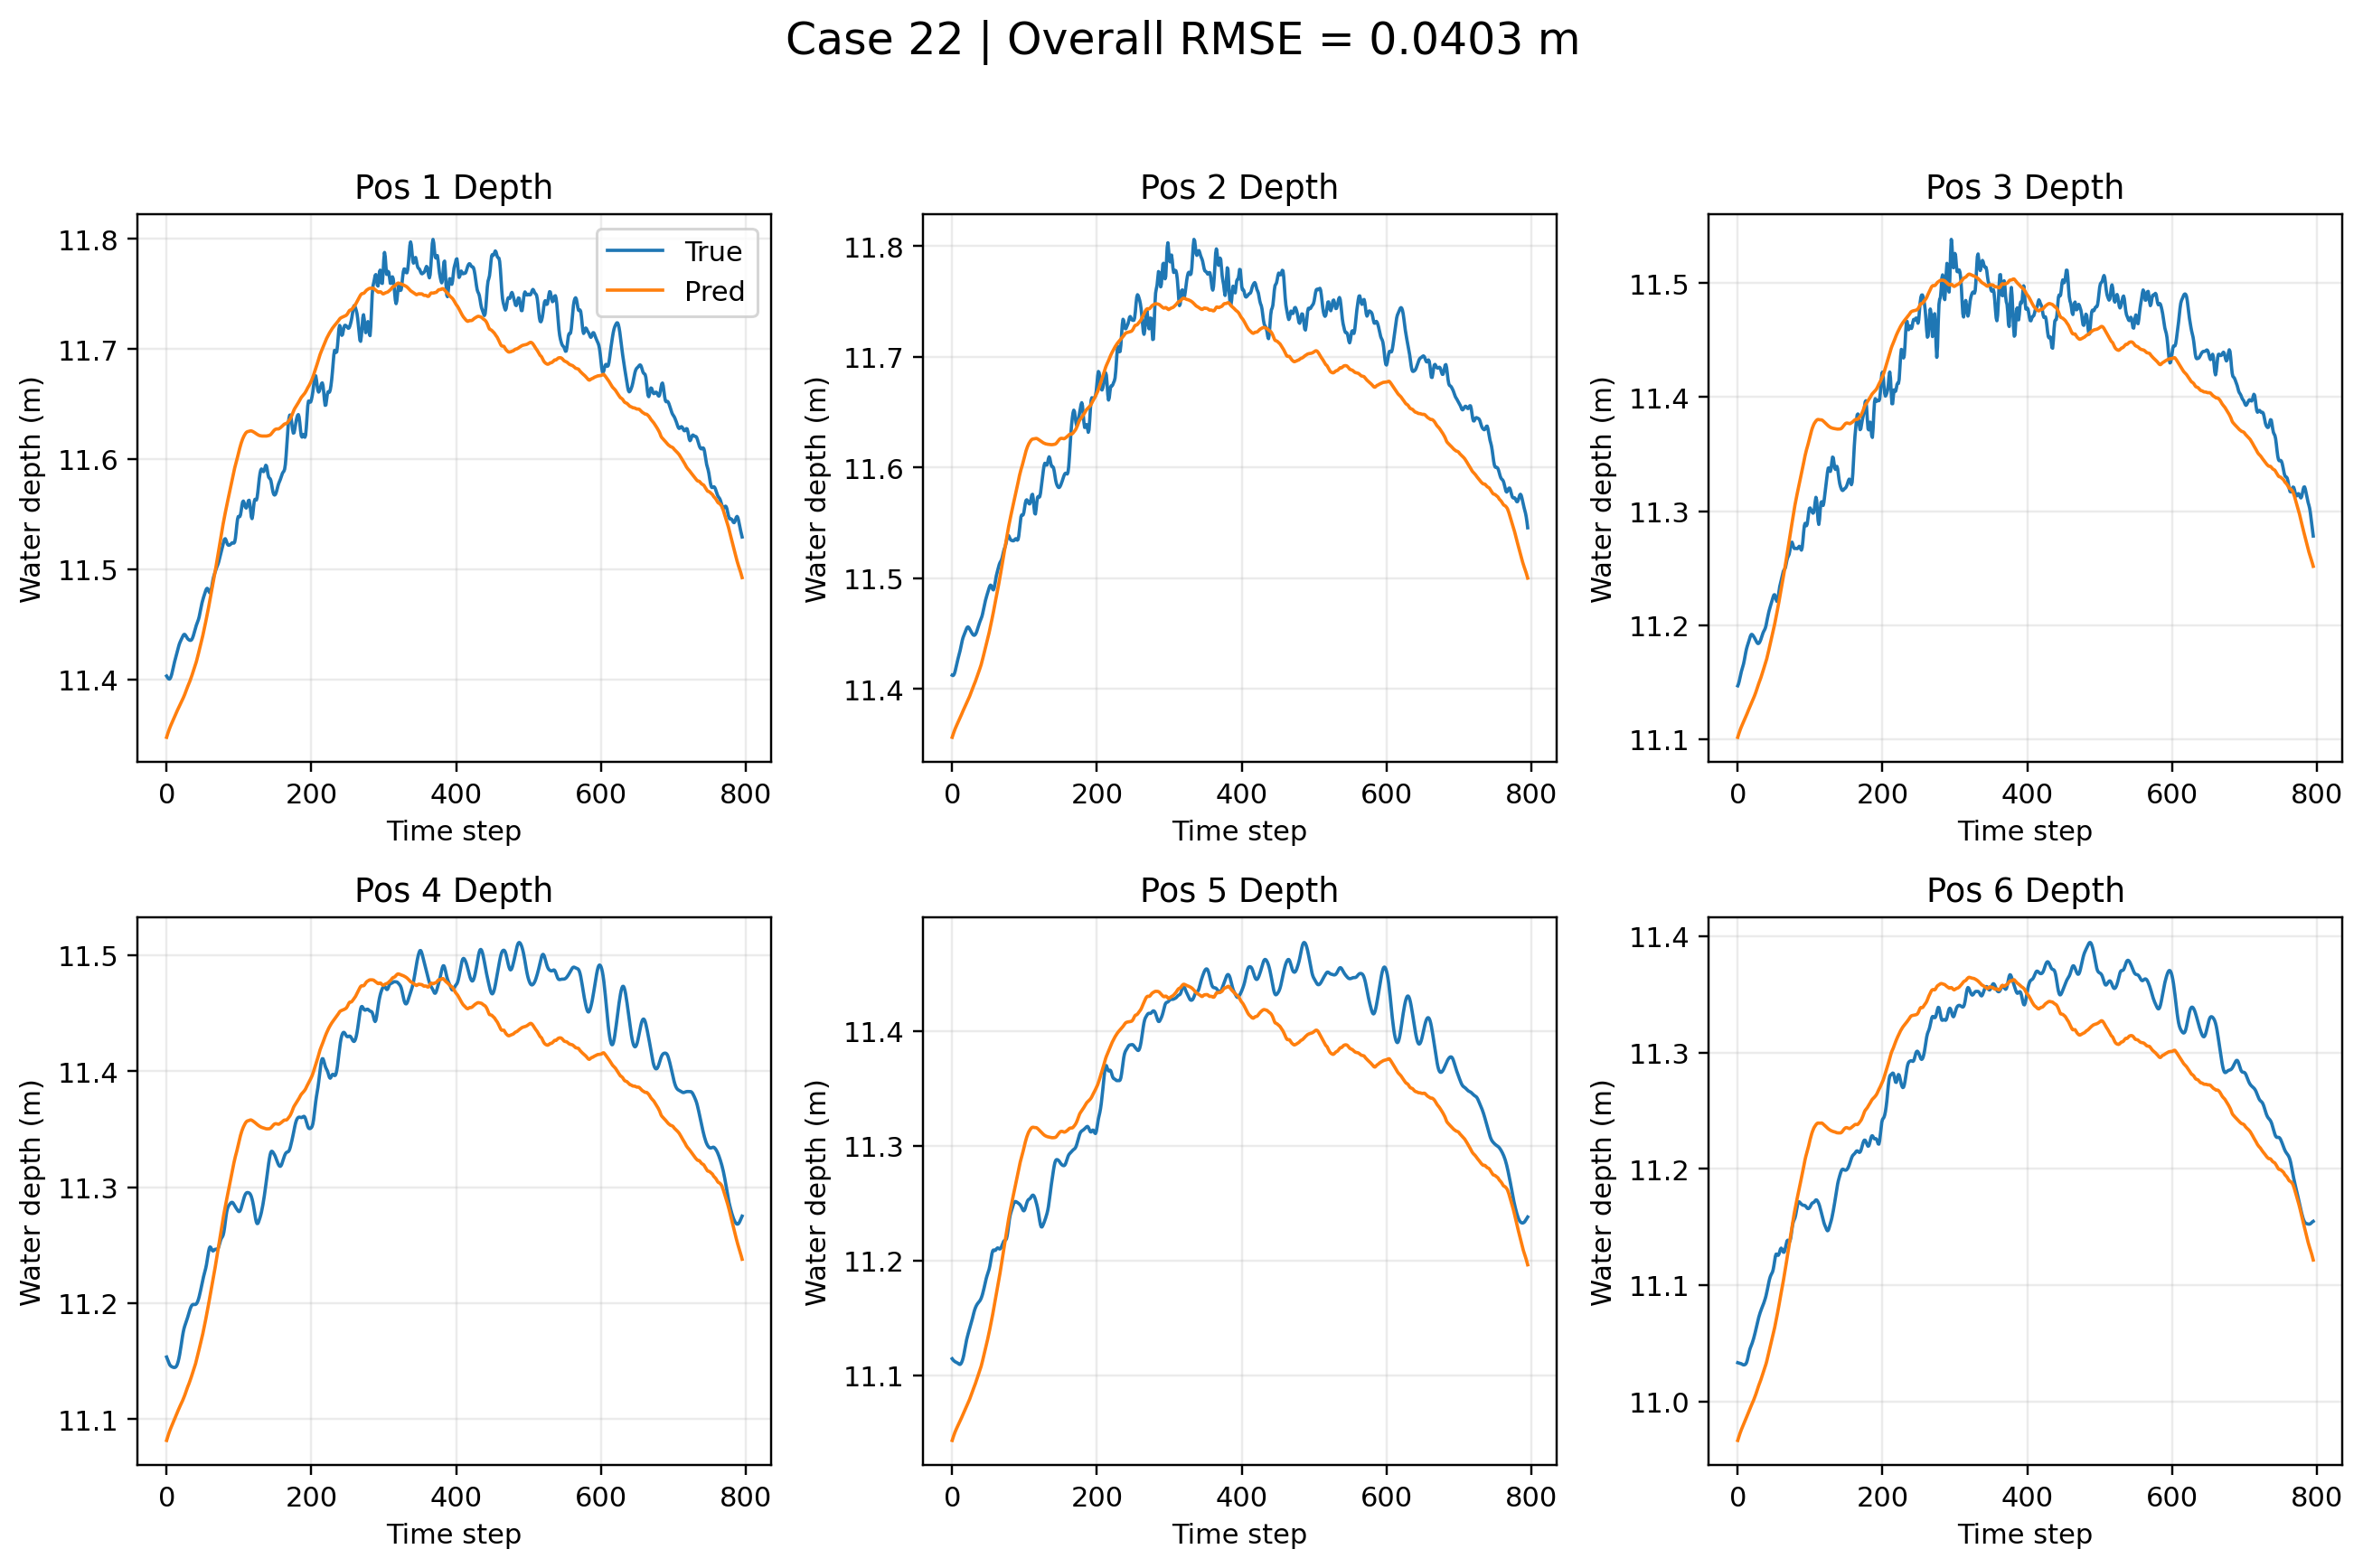

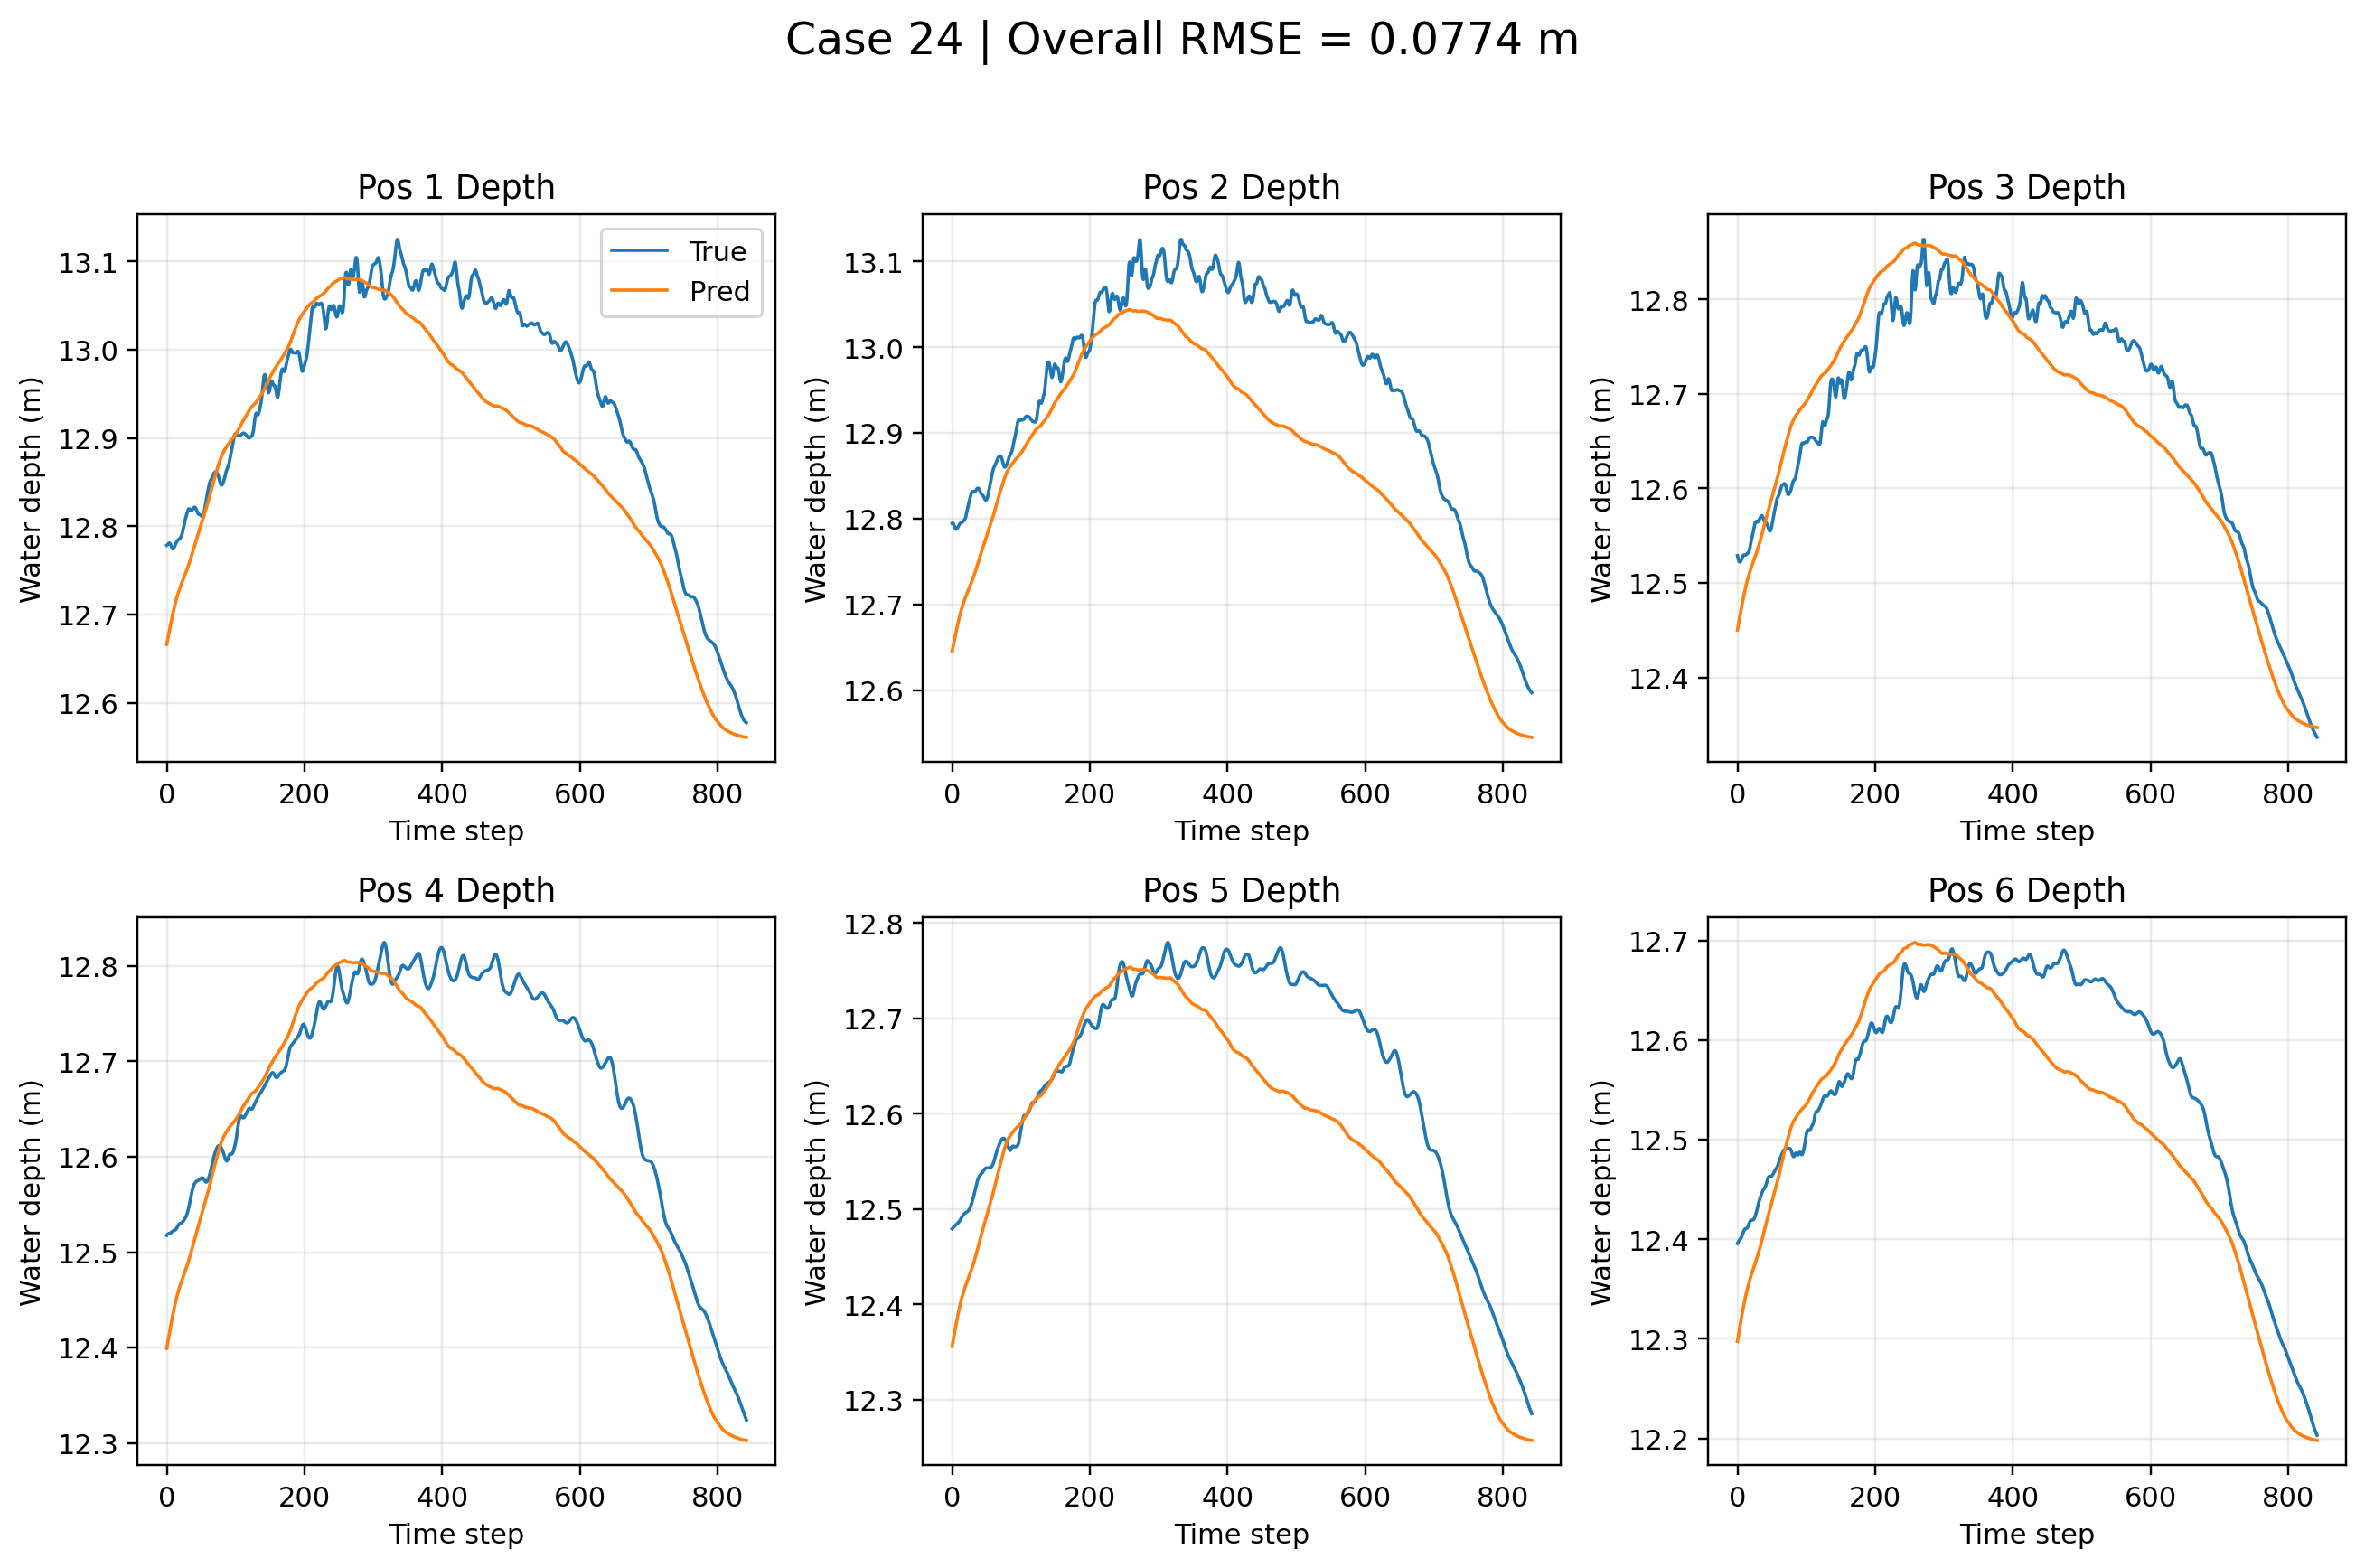

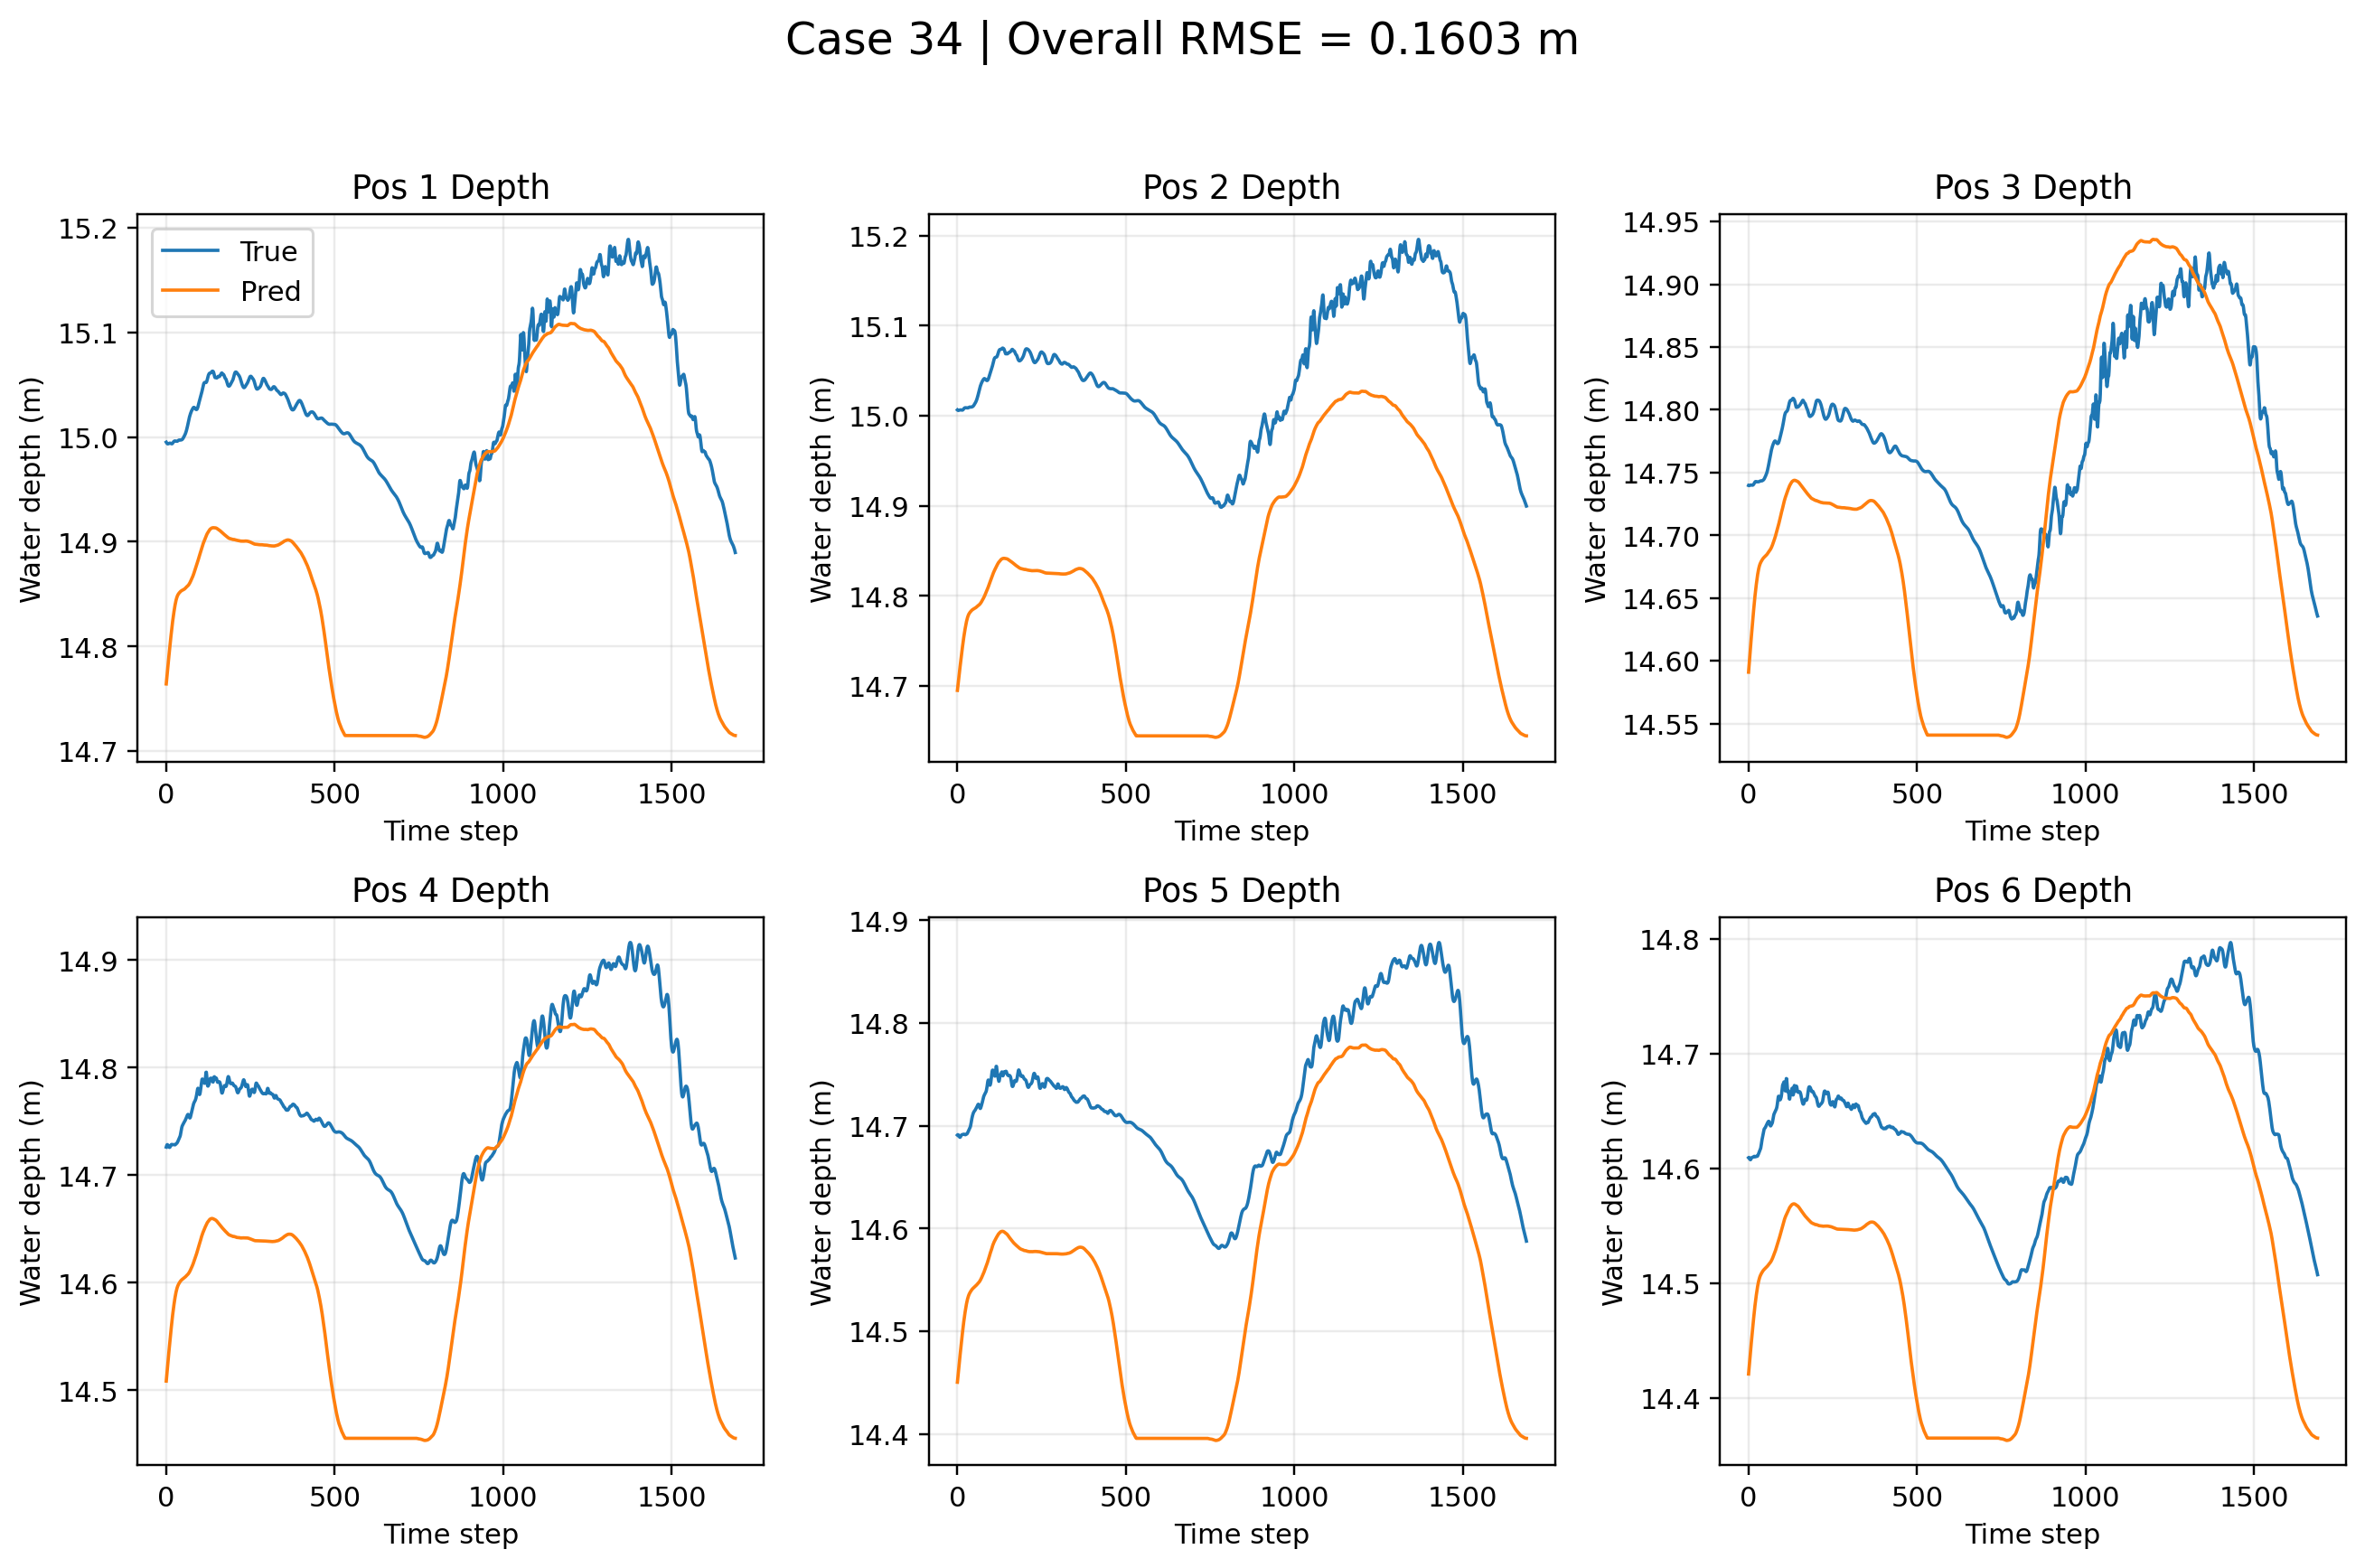

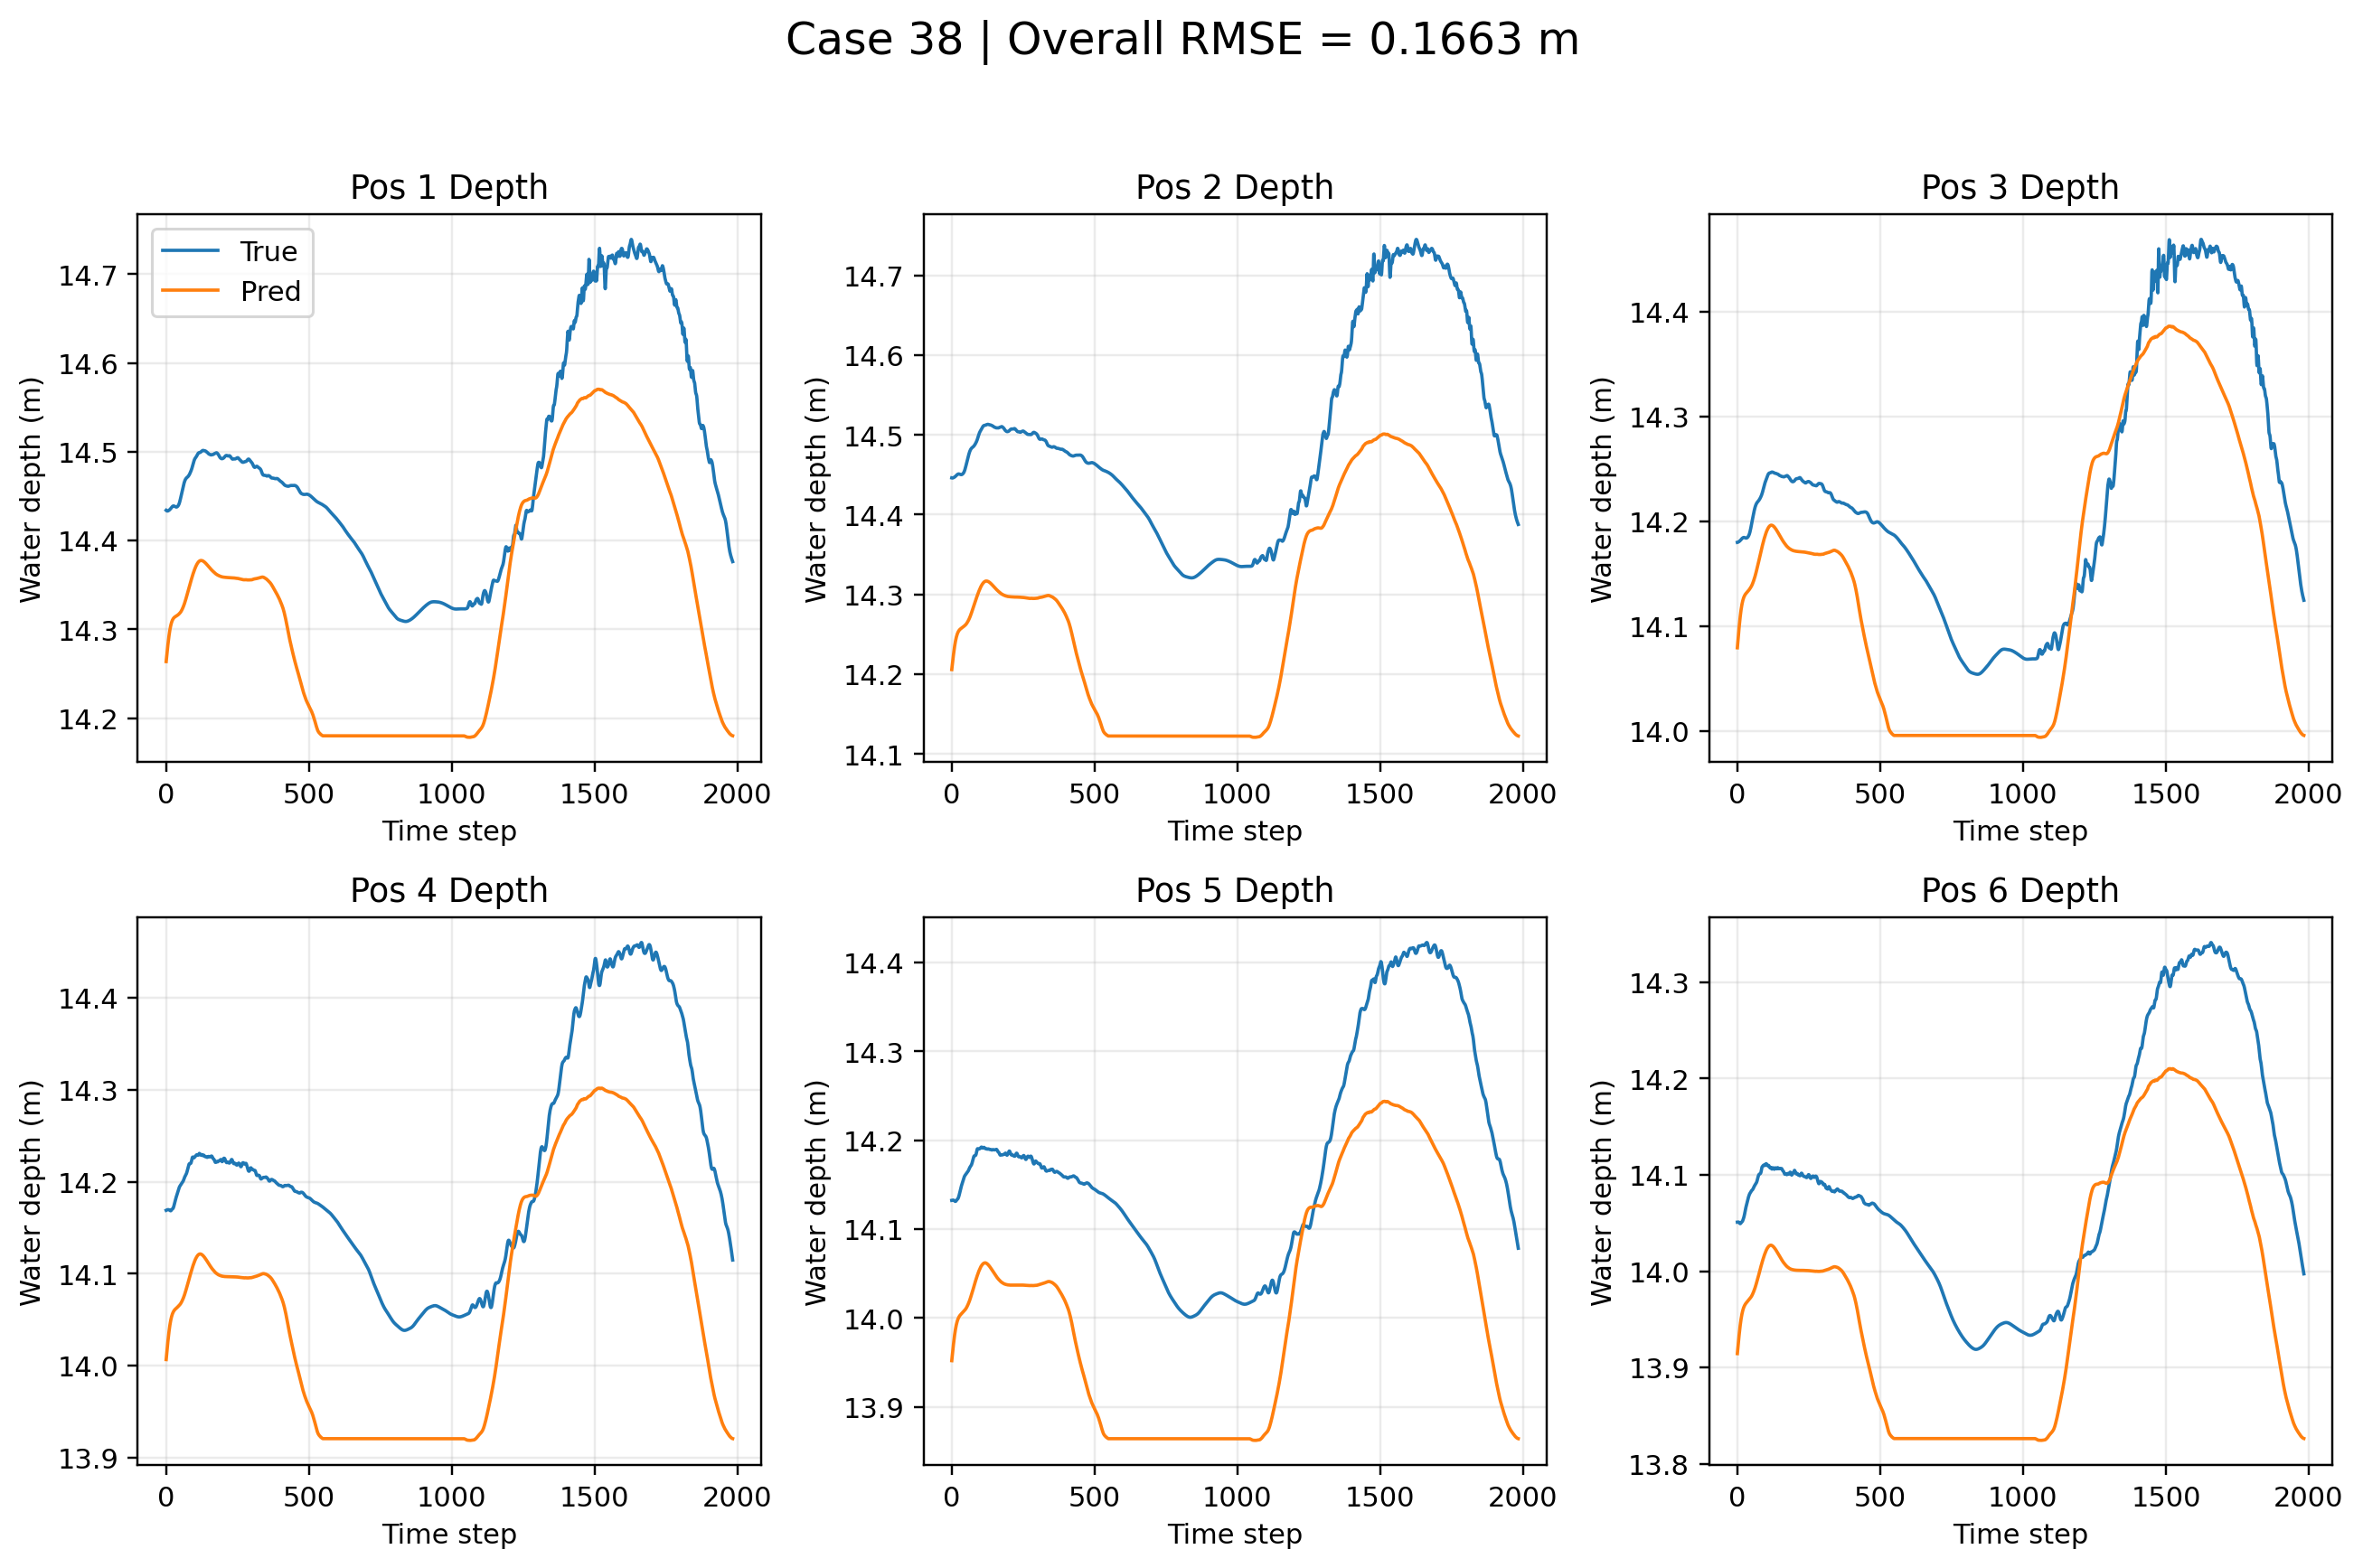

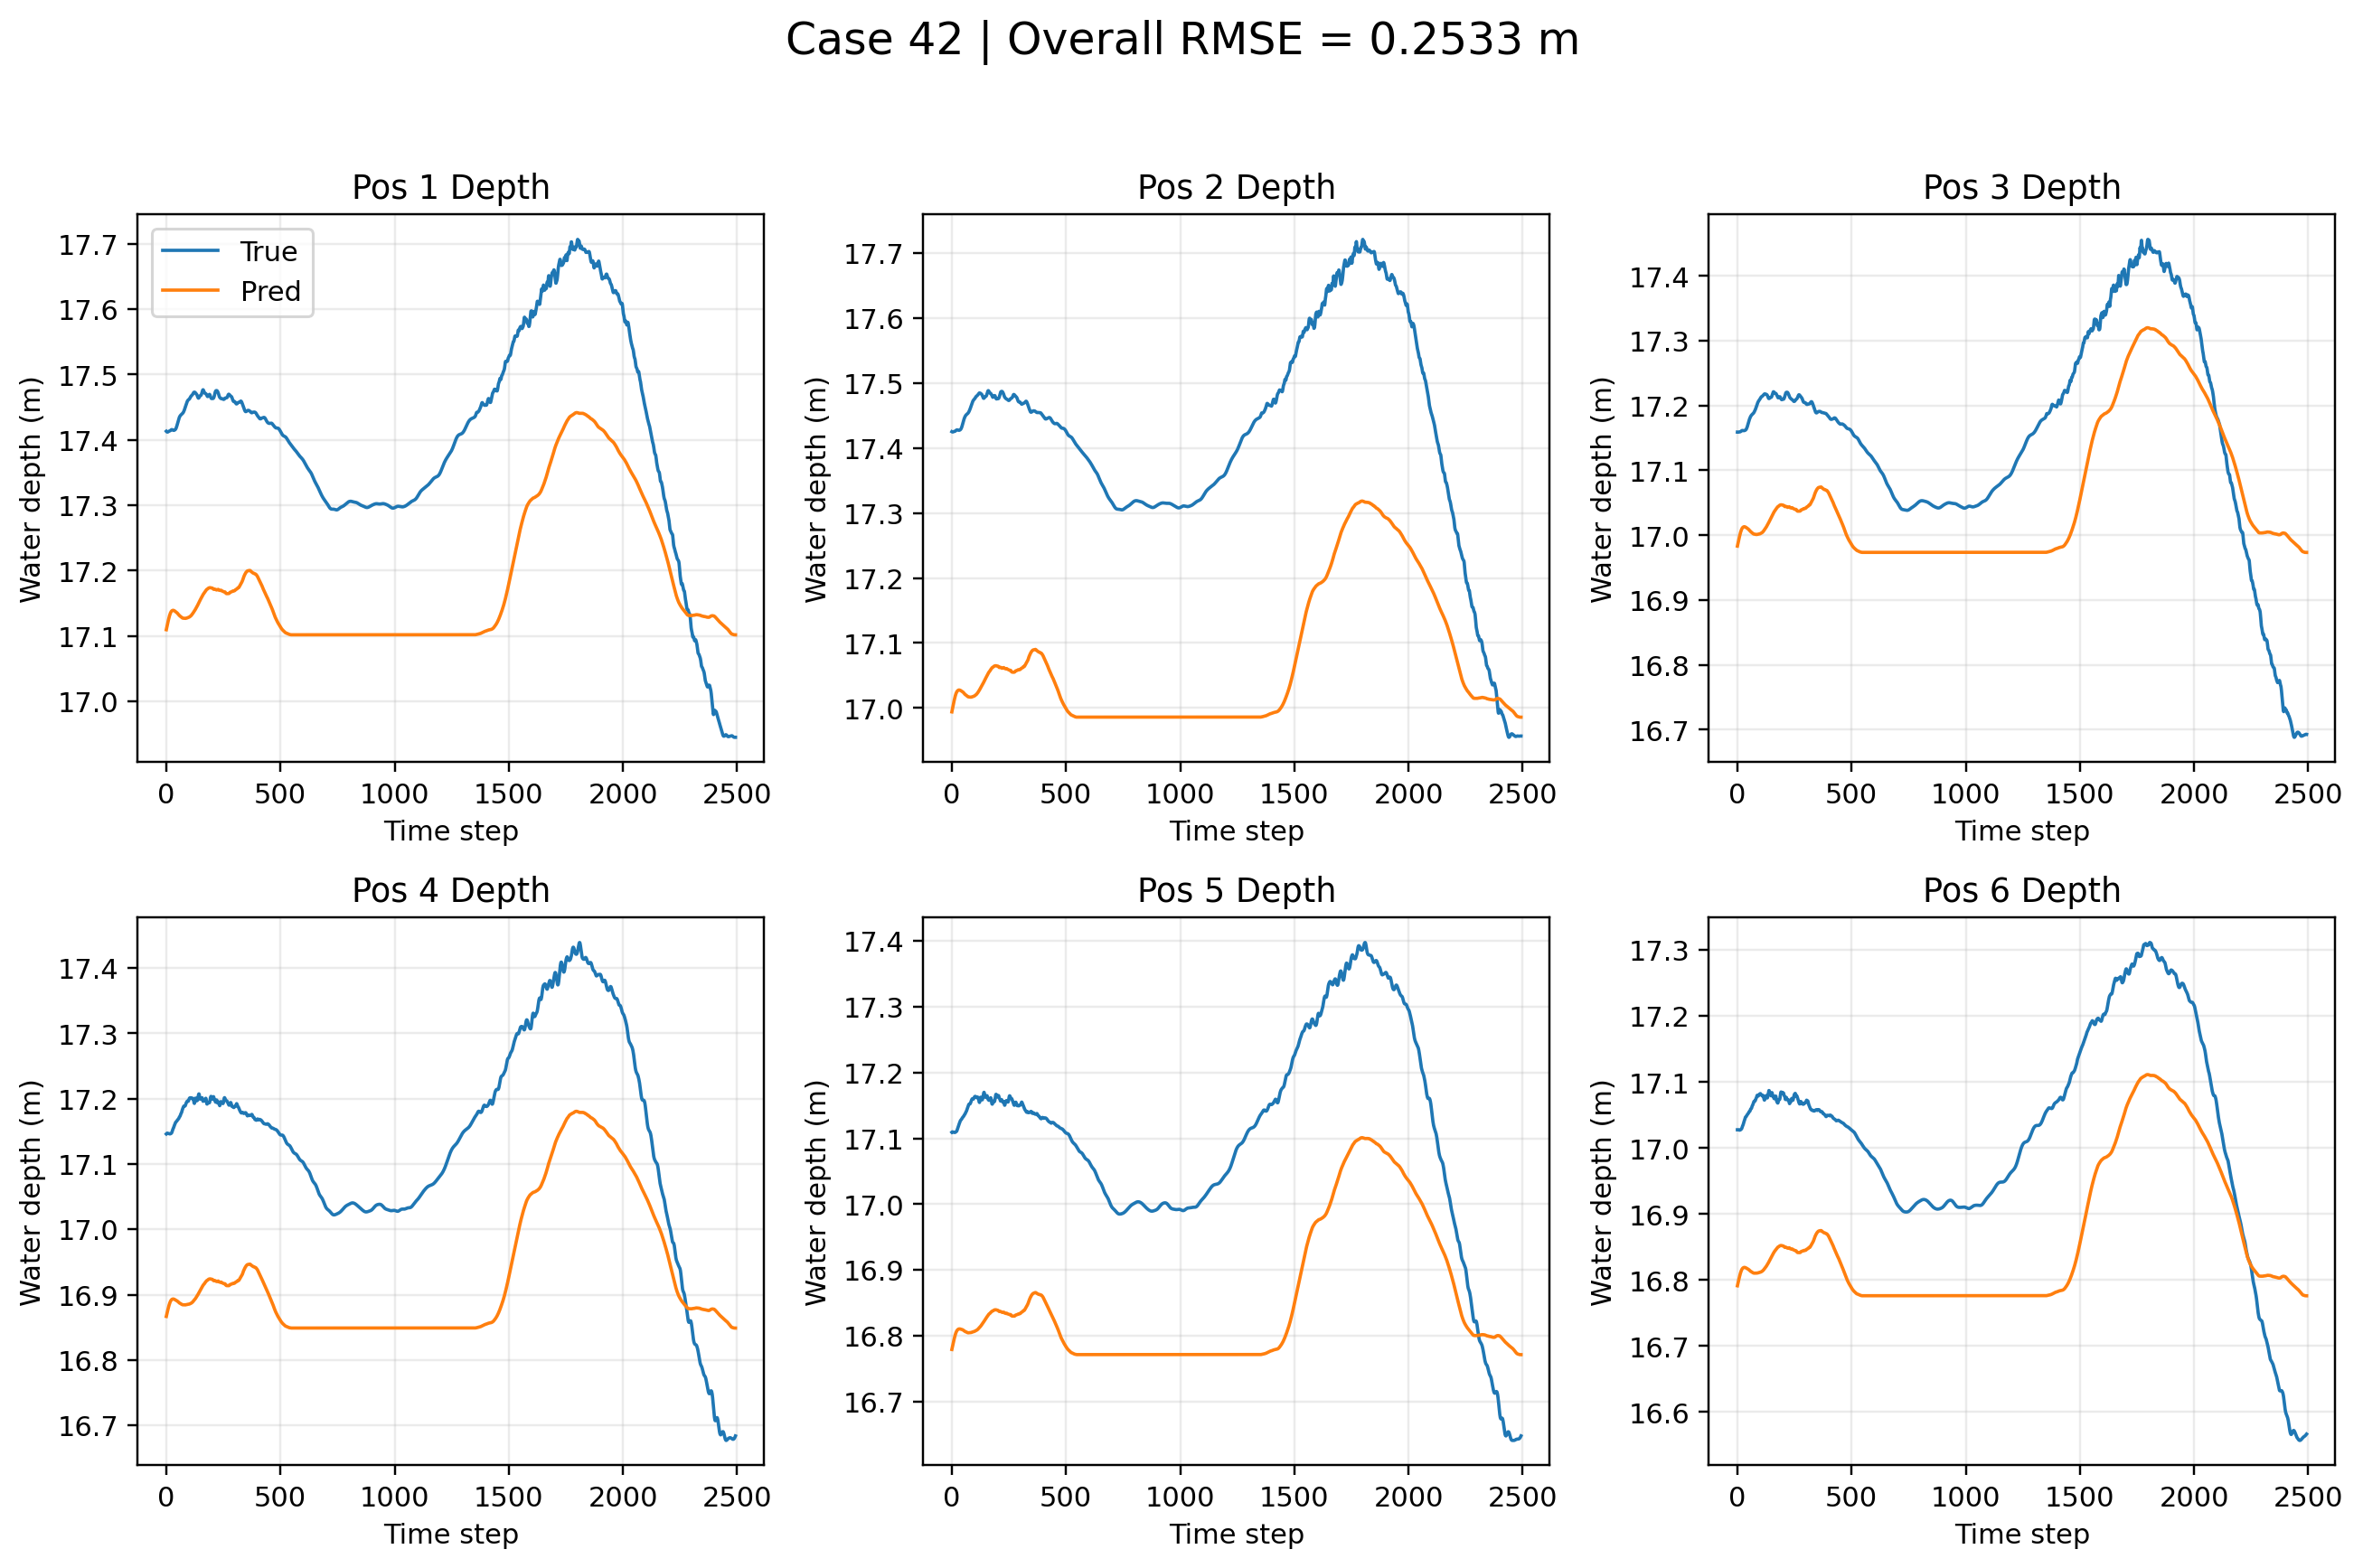

In [10]:
import matplotlib.pyplot as plt
import numpy as np

pos_names = [f"Pos {i}" for i in range(1, 7)]

for cid in sorted(test_data_per_case_norm.keys()):
    X_seq_case_norm, Y_case_norm = test_data_per_case_norm[cid]

    y_pred_case_norm = predict_norm(best_model, X_seq_case_norm, device)

    y_pred_case_real = denorm_y(y_pred_case_norm, Y_min, Y_max) 
    y_true_case_real = denorm_y(Y_case_norm, Y_min, Y_max)     

    rmse_case = float(np.sqrt(np.mean((y_pred_case_real - y_true_case_real) ** 2)))

    t = np.arange(y_true_case_real.shape[0])

    fig, axes = plt.subplots(
        2, 3,
        figsize=(12, 8),   
        dpi=220            
    )
    axes = axes.ravel()

    fig.suptitle(f"Case {cid} | Overall RMSE = {rmse_case:.4f} m", fontsize=16)

    for i in range(6):
        ax = axes[i]
        ax.plot(t, y_true_case_real[:, i], label="True", linewidth=1.2)
        ax.plot(t, y_pred_case_real[:, i], label="Pred", linewidth=1.2)

        ax.set_title(f"{pos_names[i]} Depth")
        ax.set_xlabel("Time step")
        ax.set_ylabel("Water depth (m)")
        ax.grid(True, alpha=0.25)

        if i == 0:
            ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])  
    plt.show()


In [11]:
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

best_model = torch.load(r'D:\0DATA\NHRI\小论文6  代理模型预测水深\训练过程\7、GRU\100时间步，步长1s\best_val_max_1008_test.pth', weights_only = False)

# ===== 定义评价指标 =====

def median_absolute_error(y_true, y_pred):
    """Median Absolute Error (MdAE)"""
    errors = np.abs(y_true - y_pred)
    return np.median(errors)


def iqr_based_mae(y_true, y_pred):
    """IQR-based MAE"""
    errors = np.abs(y_true - y_pred).flatten()
    q1 = np.percentile(errors, 25)
    q3 = np.percentile(errors, 75)
    mask = (errors >= q1) & (errors <= q3)
    filtered_errors = errors[mask]
    if len(filtered_errors) == 0:
        return np.nan
    return np.mean(filtered_errors)


def NSE(y_true, y_pred):
    """Nash–Sutcliffe Efficiency"""
    return 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)


def hit_rate(y_true, y_pred, delta):
    """Hit Rate (%)"""
    relative_errors = np.abs((y_pred - y_true) / y_true) * 100
    hits = relative_errors <= delta
    return np.mean(hits) * 100


def KGE(y_true, y_pred):
    """Kling–Gupta Efficiency"""
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    r = np.corrcoef(y_true, y_pred)[0, 1]
    beta = np.mean(y_pred) / np.mean(y_true)
    gamma = (np.std(y_pred) / np.mean(y_pred)) / (np.std(y_true) / np.mean(y_true))
    kge = 1 - np.sqrt((r - 1)**2 + (beta - 1)**2 + (gamma - 1)**2)
    return kge


def willmott_d(y_true, y_pred):
    """Willmott’s Index of Agreement"""
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    y_mean = np.mean(y_true)
    numerator = np.sum((y_true - y_pred)**2)
    denominator = np.sum((np.abs(y_pred - y_mean) + np.abs(y_true - y_mean))**2)
    if denominator == 0:
        return np.nan
    return 1 - numerator / denominator

def willmott_index_modified(observed, predicted):
    """
    Willmott's Modified Index of Agreement (Willmott et al., 2012)
    """
    observed = np.array(observed)
    predicted = np.array(predicted)
    
    numerator = np.sum(np.abs(predicted - observed))
    denominator = 2 * np.sum(np.abs(observed - np.mean(observed)))
    
    if denominator == 0:
        return 1.0 if numerator == 0 else 0.0
    
    d = 1 - (numerator / denominator)
    return np.clip(d, 0, 1)

max_delta = 20
deltas = np.arange(1, max_delta + 1, 1)

def evaluate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true))
    r2 = r2_score(y_true, y_pred)
    nse = NSE(y_true, y_pred)
    kge = KGE(y_true, y_pred)
    d_index = willmott_index_modified(y_true, y_pred) #willmott_d(y_true, y_pred)
    hr = [hit_rate(y_true, y_pred, d) for d in deltas]
    mdae = median_absolute_error(y_true, y_pred)
    iqr_mae = iqr_based_mae(y_true, y_pred)
    max_err = np.max(np.abs(y_true - y_pred))
    return {
        'MSE': mse, 'RMSE': rmse, 'MAPE': mape, 'MAE': mae,
        'R2': r2, 'NSE': nse, 'KGE': kge, 'd': d_index,
        'HitRate': hr, 'MdAE': mdae, 'IQR-based MAE': iqr_mae, 'MaxError': max_err
    }

# ===== 将 tensor 数据移到 GPU 并进行预测 =====
def predict(model, X_seq, device):
    model.eval()
    X_seq_t = torch.tensor(X_seq, dtype=torch.float32, device=device)
    with torch.no_grad():
        out = model(X_seq_t)  # [B, 6]
        out = out.cpu().numpy()
    return out


# ===== 总测试集预测与指标 =====
#y_pred_total = predict(best_model, X_seq_test, X_static_test, device)
y_pred_total = predict(best_model, test_X, device) 

# 反归一化
y_pred_total_real = y_pred_total * (Y_max - Y_min) + Y_min
Y_test_real = Y_test * (Y_max - Y_min) + Y_min

metrics_total = evaluate_metrics(Y_test_real, y_pred_total_real)
print("===== 总测试集指标 =====")
for k, v in metrics_total.items():
    if k != "HitRate":
        print(f"{k}: {v:.6f}")
    else:
        print(f"Hit Rate : ", v)

# ===== 各工况测试集指标（加入归一化） =====
save_excel_path = r"D:\0DATA\NHRI\小论文6  代理模型预测水深\训练过程\7、GRU\100时间步，步长1s\预测结果.xlsx"
print("\n===== 各工况测试集指标 =====")
for case_name, case_data in test_data_per_case.items():
    # 原始数据
    X_seq_case = case_data[0]   # 形状 (N, seq_len, 2)
    X_static_case = case_data[1]  # 形状 (N, 1)
    Y_case = case_data[2]

    # --- 归一化 & 拼接静态特征 ---
    X_seq_flat = X_seq_case.reshape(-1, X_seq_case.shape[-1])
    X_seq_case_norm = (X_seq_flat - X_seq_min) / (X_seq_max - X_seq_min + 1e-8)
    X_seq_case_norm = X_seq_case_norm.reshape(X_seq_case.shape)

    X_static_case_norm = (X_static_case - X_static_min) / (X_static_max - X_static_min + 1e-8)

    # 拼接静态特征到时间序列最后一维
    X_case_input = np.concatenate(
        [X_seq_case_norm, np.repeat(X_static_case_norm[:, np.newaxis, :], X_seq_case_norm.shape[1], axis=1)],
        axis=-1
    )

    # --- 预测 ---
    y_pred_case = predict(best_model, X_case_input, device)

    # --- 反归一化 ---
    y_pred_case_real = y_pred_case * (Y_max - Y_min) + Y_min
    Y_case_real = Y_case

    # --- 计算指标 ---
    metrics_case = evaluate_metrics(Y_case_real, y_pred_case_real)
    print(f"\n工况 {case_name} 指标:")
    for k, v in metrics_case.items():
        if k != "HitRate":
            print(f"{k}: {v:.6f}")
        else:
            print(f"Hit Rate : ", v)

    # --- 构建 DataFrame ---
    num_points = Y_case_real.shape[1]  # 假设输出为 [样本数, 6]
    columns_actual = [f"Simulated (Pos {i+1})" for i in range(num_points)] # Simulated (Pos 1)
    columns_pred = [f"Predicted (Pos {i+1})" for i in range(num_points)]

    df_case = pd.DataFrame(
        np.hstack([Y_case_real, y_pred_case_real]),
        columns=columns_actual + columns_pred
    )

    # --- 保存到 Excel（不同工况分 sheet） ---
    with pd.ExcelWriter(save_excel_path, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
        df_case.to_excel(writer, index=False, sheet_name=f"{case_name}_预测结果")

print(f"\n✅ 所有工况的预测结果已保存到: {save_excel_path}")

C:\Users\Administrator\AppData\Local\Temp\ipykernel_30024\3838884894.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_seq_t = torch.tensor(X_seq, dtype=torch.float32, device=device)


===== 总测试集指标 =====
MSE: 28324.251953
RMSE: 168.298104
MAPE: 0.923876
MAE: 166.608475
R2: -41.548435
NSE: -41.280064
KGE: 0.074068
d: 0.000000
Hit Rate :  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
MdAE: 169.839905
IQR-based MAE: 163.910049
MaxError: 211.596024

===== 各工况测试集指标 =====

工况 3 指标:
MSE: 0.004126
RMSE: 0.064235
MAPE: 0.004280
MAE: 0.049666
R2: 0.707005
NSE: 0.888159
KGE: 0.934250
d: 0.839492
Hit Rate :  [88.88333333333334, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
MdAE: 0.038738
IQR-based MAE: 0.040052
MaxError: 0.172606

工况 6 指标:
MSE: 0.002935
RMSE: 0.054173
MAPE: 0.003050
MAE: 0.043747
R2: 0.378007
NSE: 0.895715
KGE: 0.890039
d: 0.845867
Hit Rate :  [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
MdAE: 0.039854
IQR-based MAE: 0.040536
Ma